In [92]:
# % pylab inline
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot,plot
import matplotlib.pyplot as plt
init_notebook_mode()
import CCD_packages
reload(CCD_packages)

<module 'CCD_packages' from 'CCD_packages.py'>

In [2]:
GroupDF,motionInfo=CCD_packages.getCCDSubjectData(saveMotionInfo=False,zscoreOn=True)

No DR .txt file found or error for subject : CCD061
No DR .txt file found or error for subject : CCD061


In [91]:
! git pull

remote: Counting objects: 4, done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/jordanmuraskin/CCD-scripts
   9c84cbb..5b6d8b0  master     -> origin/master
Updating 9c84cbb..5b6d8b0
Fast-forward
 analysis/CCD_packages.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [93]:
goodsubj,badsubj,poorperformer = CCD_packages.getSubjectList(GroupDF=GroupDF,motionThresh=1,poor_performer=14)

In [95]:
print badsubj
print len(goodsubj)
print poorperformer

['CCD033' 'CCD066' 'CCD072' 'CCD076' 'CCD086' 'CCD093' 'CCD096']
43
['CCD034' 'CCD065' 'CCD075' 'CCD080']


CCD_packages.py:1074: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



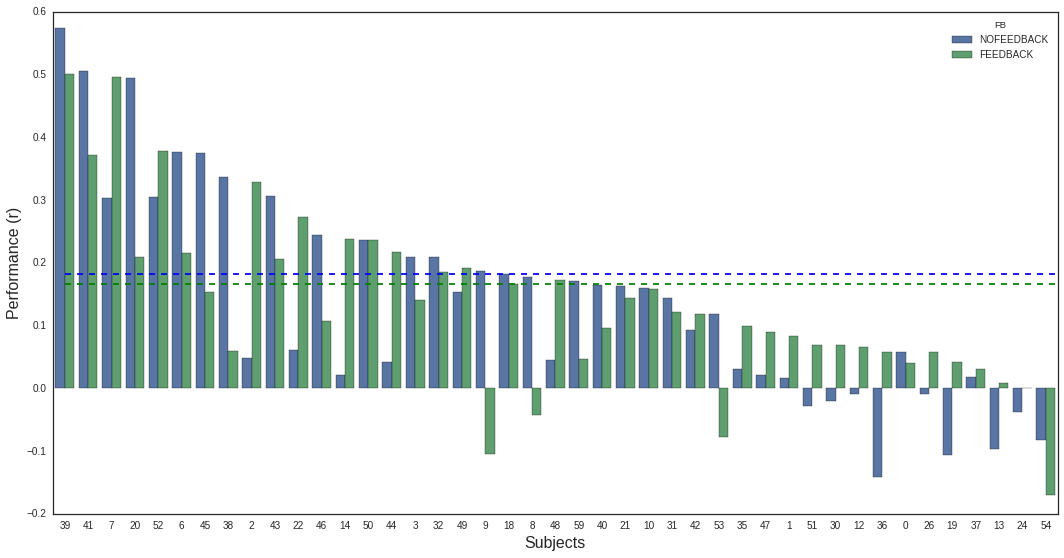

In [64]:
r05=CCD_packages.createSubjectModelBarPlot(GroupDF,goodsubj,figsize=(18,9),savefig=False)
plt.xlabel('Subjects',fontsize=16)
plt.ylabel('Performance (r)',fontsize=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

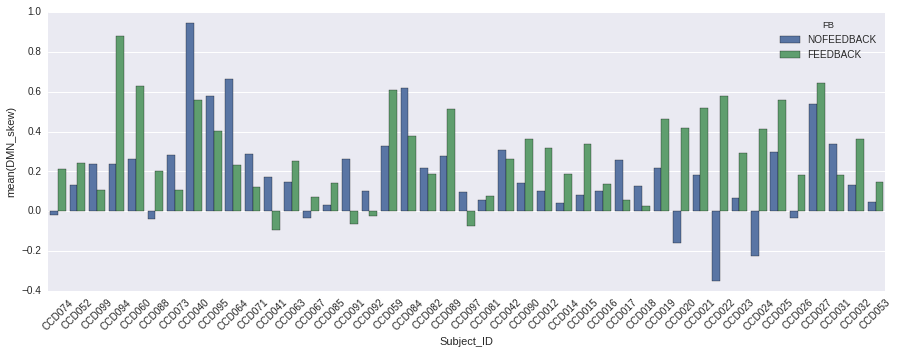

In [4]:
from scipy.stats import skew,ttest_1samp
import seaborn as sns

skewData=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB'])['DMN_skew'].mean()
perfData=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB'])['modelcorr'].mean()
# skewData
# help(sns.barplot)
plt.figure(figsize=(15,5))
sns.barplot(x='Subject_ID',y='DMN_skew',data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],hue='FB')
plt.xticks(rotation=45)

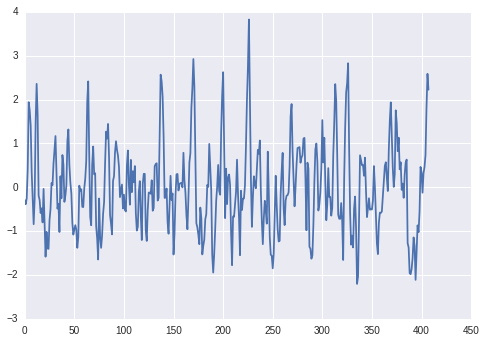

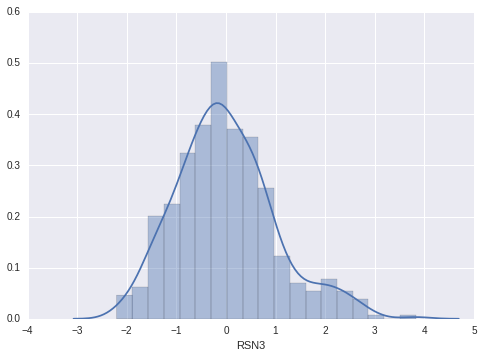

In [5]:
plt.figure()
plt.plot(range(408),GroupDF[np.all([GroupDF.Subject_ID=='CCD022',GroupDF.FB=='FEEDBACK'],axis=0)]['RSN3'])
plt.figure()
sns.distplot(GroupDF[np.all([GroupDF.Subject_ID=='CCD022',GroupDF.FB=='FEEDBACK'],axis=0)]['RSN3'])

In [16]:
t,p=ttest_1samp(skewData.loc[:,'FEEDBACK']-skewData.loc[:,'NOFEEDBACK'],0)
p

0.036717352352185761

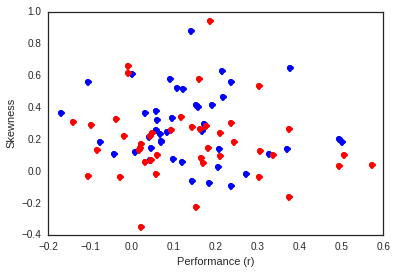

In [117]:
plt.plot(perfData.loc[:,'FEEDBACK'],skewData.loc[:,'FEEDBACK'],'bo')
plt.plot(perfData.loc[:,'NOFEEDBACK'],skewData.loc[:,'NOFEEDBACK'],'ro')
plt.xlabel('Performance (r)')
plt.ylabel('Skewness')



In [41]:
blockedDF=CCD_packages.getBlockedPerformance(GroupDF,goodsubj)
blockedDF.keys()

Index([u'Condition', u'FB', u'average', u'std', u'subj', u'RSN'], dtype='object')

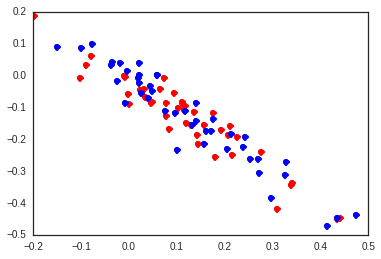

In [43]:
plt.plot(blockedDF[np.all([blockedDF.FB=='FEEDBACK',blockedDF.Condition=='Wander'],axis=0)]['average'],blockedDF[np.all([blockedDF.FB=='FEEDBACK',blockedDF.Condition=='Focus'],axis=0)]['average'],'ro')
plt.plot(blockedDF[np.all([blockedDF.FB=='NOFEEDBACK',blockedDF.Condition=='Wander'],axis=0)]['average'],blockedDF[np.all([blockedDF.FB=='NOFEEDBACK',blockedDF.Condition=='Focus'],axis=0)]['average'],'bo')

In [55]:

ts=GroupDF[np.all([GroupDF.Subject_ID=='CCD053',GroupDF.FB=='FEEDBACK'],axis=0)]['RSN3']

215

In [56]:
GroupDF['PosNeg']=GroupDF['RSN3']>0

In [57]:
posneg=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB'])['PosNeg'].sum()

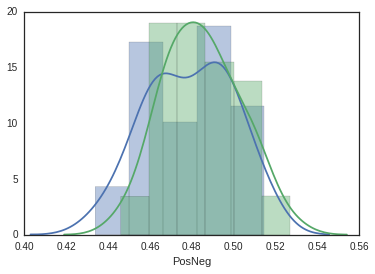

In [60]:
sns.distplot(posneg.loc[:,'FEEDBACK']/408)
sns.distplot(posneg.loc[:,'NOFEEDBACK']/408)

In [62]:
t,p=ttest_1samp(posneg.loc[:,'FEEDBACK']-posneg.loc[:,'NOFEEDBACK'],0)
t

-1.575013559059389

In [6]:
wander=np.zeros(408,)
focus=np.zeros(408,)

In [7]:
wander[11:26]=1
wander[75:105]=1
wander[124:169]=1
wander[203:233]=1
wander[282:297]=1
wander[331:375]=1

focus[28:73]=-1
focus[107:122]=-1
focus[171:201]=-1
focus[235:280]=-1
focus[299:329]=-1
focus[378:393]=-1


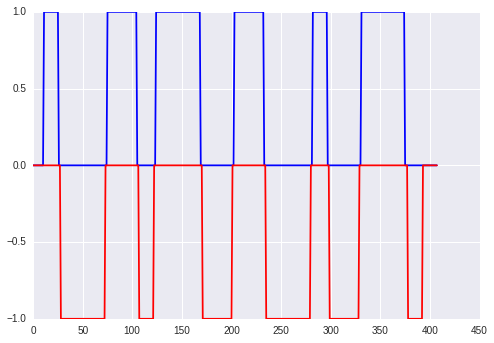

In [8]:
plt.plot(range(408),wander,'b',range(408),focus,'r')

In [9]:
from scipy.stats import gamma
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
#     undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values #- 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 1

In [10]:
TR = 2
tr_times = np.arange(0, 30, TR)
hrf_at_trs = hrf(tr_times)

In [11]:
wander_convolved = np.convolve(wander, hrf_at_trs,mode='same')
focus_convolved = np.convolve(focus, hrf_at_trs,mode='same')

# N = len(wander)  # M == n_vols == 173
# M = len(hrf_at_trs)  # M == 12

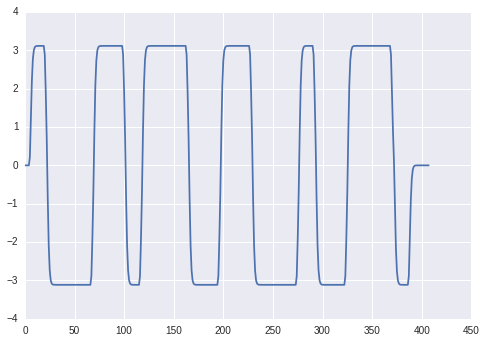

In [12]:
plt.plot(wander_convolved+focus_convolved)

In [24]:
dmnIdeal=read_csv('/home/jmuraskin/Projects/NFB/analysis/DMN_ideal_2.csv')


In [25]:
from scipy.stats import pearsonr

print pearsonr(dmnIdeal['Wander']-dmnIdeal['Focus'],wander_convolved+focus_convolved)

(0.5906103593585269, 1.0124570889928053e-39)


In [254]:
subject='CCD014'
fb='NOFEEDBACK'

print pearsonr(GroupDF[np.all([GroupDF.Subject_ID==subject,GroupDF.FB==fb],axis=0)]['RSN3'],dmnIdeal['Wander']-dmnIdeal['Focus'])
print pearsonr(GroupDF[np.all([GroupDF.Subject_ID==subject,GroupDF.FB==fb],axis=0)]['RSN3'],wander_convolved+focus_convolved)

(0.57349609405824775, 4.7297262247709749e-37)
(0.33191613440131429, 5.9933131530133162e-12)


In [111]:
import statsmodels.api as sm

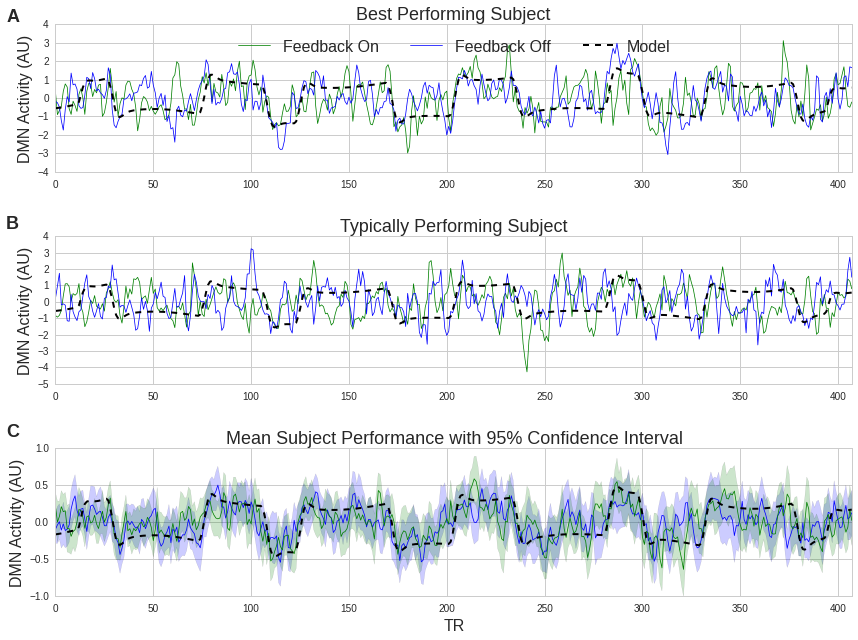

In [128]:
# c=np.column_stack([GroupDF[np.all([GroupDF.Subject_ID==subject,GroupDF.FB==fb],axis=0)]['RSN3'],CCD_packages.zscore(dmnIdeal['Wander']),CCD_packages.zscore(dmnIdeal['Focus'])])
# p=CCD_packages.partial_corr(c)
# p[0,2]
subject='CCD014'
f,ax=plt.subplots(3,1,figsize=(12,9))
sns.set_style("whitegrid")
GroupDF[np.all([GroupDF.Subject_ID==subject,GroupDF.FB=='FEEDBACK'],axis=0)][['TR','RSN3']].plot(x='TR',y='RSN3',color='g',ax=ax[0],label='Feedback On',linewidth=.75)
GroupDF[np.all([GroupDF.Subject_ID==subject,GroupDF.FB=='NOFEEDBACK'],axis=0)][['TR','RSN3']].plot(x='TR',y='RSN3',color='b',ax=ax[0],label='Feedback Off',linewidth=.75)
# x=ax.get_xlim()
# print(x)
# print len(np.arange(x[0],x[1],408))
ax[0].plot(range(408),dmnIdeal['Wander']-dmnIdeal['Focus'],'k--',label='Model',linewidth=2)


# ax[0].grid()
ax[0].set_ylabel("DMN Activity (AU)",fontsize=16)
ax[0].set_xlabel("")
ax[0].legend(fontsize=16,ncol=3,loc=9)
ax[0].set_title('Best Performing Subject',fontsize=18)

GroupDF[np.all([GroupDF.Subject_ID=='CCD063',GroupDF.FB=='FEEDBACK'],axis=0)][['TR','RSN3']].plot(x='TR',y='RSN3',color='g',ax=ax[1],label='Feedback On',linewidth=.75)
GroupDF[np.all([GroupDF.Subject_ID=='CCD063',GroupDF.FB=='NOFEEDBACK'],axis=0)][['TR','RSN3']].plot(x='TR',y='RSN3',color='b',ax=ax[1],label='Feedback Off',linewidth=.75)
# x=ax.get_xlim()
# print(x)
# print len(np.arange(x[0],x[1],408))
ax[1].plot(range(408),dmnIdeal['Wander']-dmnIdeal['Focus'],'k--',label='model',linewidth=2)
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
# ax[1].grid()
ax[1].set_ylabel("DMN Activity (AU)",fontsize=16)
ax[1].set_xlabel("")
ax[1].legend().set_visible(False)
ax[1].set_title('Typically Performing Subject',fontsize=18)

sns.tsplot(data=GroupDF[GroupDF.Subject_ID.isin(goodsubj)],time='TR',unit='Subject',condition='FB',value='RSN3',ci=95,ax=ax[2],color=['b','g'],linewidth=.75)
# sns.set_style("whitegrid")

ax[2].plot(range(408),(dmnIdeal['Wander']-dmnIdeal['Focus'])*.3,'k--',label='model',linewidth=2)
ax[2].set_ylim([-1,1])
# ax[2].grid()
ax[2].set_ylabel("DMN Activity (AU)",fontsize=16)
ax[2].set_xlabel('TR',fontsize=16)
ax[2].legend().set_visible(False)
ax[2].set_title('Mean Subject Performance with 95% Confidence Interval',fontsize=18)

plt.figtext(0.01,.96,'A',fontsize=18,figure=f,weight='bold')
plt.figtext(0.01,.64,'B',fontsize=18,figure=f,weight='bold')
plt.figtext(0.01,.32,'C',fontsize=18,figure=f,weight='bold')
f.tight_layout(h_pad=3)
f.savefig('%s/TimeSeriesPerformance.png' % CCD_packages.saveFigureLocation,dpi=600)


In [20]:
r_scramble=np.mean(CCD_packages.get_null_correlations(GroupDF,goodsubj,nperms=1000,p=0.05),axis=0)

CCD_packages.py:1152: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [21]:
performance=GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB'])['modelcorr'].mean()

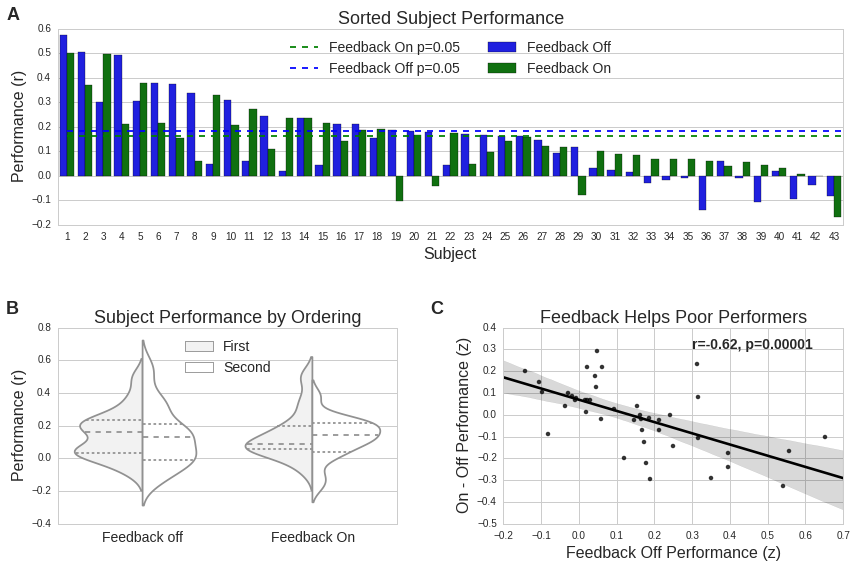

In [28]:
# f,axes=plt.subplots()
f=plt.figure(figsize=(12,8))
ax1=plt.subplot2grid((2,2),(0,0), colspan=2)
ax2=plt.subplot2grid((2,2),(1,0))
ax3=plt.subplot2grid((2,2),(1,1))
sns.set_style("whitegrid")
r05=CCD_packages.createSubjectModelBarPlot(GroupDF,goodsubj,r_scramble,savefig=False,ax=ax1,palette=['b','g'])
ax1.set_xticklabels(range(1,44))
ax1.set_xlabel('Subject',fontsize=16)
ax1.set_ylabel('Performance (r)',fontsize=16)
# ax1.yaxis.grid()
ax1.set_title('Sorted Subject Performance',fontsize=18)
handles, labels = ax1.get_legend_handles_labels()
labels[0]='Feedback On p=0.05'
labels[1]='Feedback Off p=0.05'
labels[2]='Feedback Off'
labels[3]='Feedback On'
ax1.legend(handles,labels,ncol=2,loc=9,fontsize=14)
sns.set_style("whitegrid")

# ax1.legend(['Feedback Off','Feedback On'])
CCD_packages.createScanOrderBarPlot(GroupDF,goodsubj,ax=ax2,savefig=False)
sns.set_style("whitegrid")
ax2.set_xticklabels(['Feedback off','Feedback On'],fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Performance (r)', fontsize=16)
# ax2.yaxis.grid()
ax2.set_title('Subject Performance by Ordering',fontsize=18)
handles, labels = ax2.get_legend_handles_labels()
labels[0]='First'
labels[1]='Second'
ax2.legend(handles,labels,fontsize=14,loc=9)

sns.regplot(x=np.arctanh(performance.loc[:,'NOFEEDBACK']),y=np.arctanh(performance.loc[:,'FEEDBACK'])-np.arctanh(performance.loc[:,'NOFEEDBACK']),ax=ax3,ci=95,color='k')
sns.set_style("whitegrid")

ax3.set_ylabel('On - Off Performance (z)',fontsize=16)
ax3.set_xlabel('Feedback Off Performance (z)',fontsize=16)
# ax3.grid()
r,p=pearsonr(np.arctanh(performance.loc[:,'NOFEEDBACK']),np.arctanh(performance.loc[:,'FEEDBACK'])-np.arctanh(performance.loc[:,'NOFEEDBACK']))
ax3.annotate('r=%0.2f, p=%0.5f' % (r,p),xy=(.3,.3),fontsize=14,weight='semibold')
ax3.set_title('Feedback Helps Poor Performers',fontsize=18)
plt.figtext(0.01,.96,'A',fontsize=18,figure=f,weight='bold')
plt.figtext(0.01,.45,'B',fontsize=18,figure=f,weight='bold')
plt.figtext(0.5,.45,'C',fontsize=18,figure=f,weight='bold')
f.tight_layout(w_pad=5, h_pad=4)
f.savefig('%s/SubjectPerformance.png' % CCD_packages.saveFigureLocation,dpi=600)
# plt.xlabel('Subjects',fontsize=16)
# plt.ylabel('Performance (r)',fontsize=16)

In [507]:
performance.loc[helps,:]

Subject_ID  FB        
CCD017      FEEDBACK      0.118869
            NOFEEDBACK    0.092818
CCD019      FEEDBACK      0.216340
            NOFEEDBACK    0.042248
CCD022      FEEDBACK      0.089841
            NOFEEDBACK    0.021302
CCD023      FEEDBACK      0.172657
            NOFEEDBACK    0.045068
CCD024      FEEDBACK      0.191706
            NOFEEDBACK    0.153730
CCD026      FEEDBACK      0.069145
            NOFEEDBACK   -0.028620
CCD041      FEEDBACK      0.237117
            NOFEEDBACK    0.020552
CCD042      FEEDBACK      0.058407
            NOFEEDBACK   -0.141224
CCD052      FEEDBACK      0.082629
            NOFEEDBACK    0.016359
CCD059      FEEDBACK      0.000104
            NOFEEDBACK   -0.038123
CCD064      FEEDBACK      0.066361
            NOFEEDBACK   -0.008591
CCD067      FEEDBACK      0.041894
            NOFEEDBACK   -0.105816
CCD071      FEEDBACK      0.007870
            NOFEEDBACK   -0.096818
CCD081      FEEDBACK      0.098744
            NOFEEDBACK    0.0300

In [541]:
helps=[]
hurts=[]
for subj in goodsubj:
    help_hurt=(performance.loc[subj,'FEEDBACK']-performance.loc[subj,'NOFEEDBACK'])>0 and performance.loc[subj,'NOFEEDBACK']<.18
    if help_hurt:
        helps.append(subj)
    else:
        hurts.append(subj)
# helps=np.all([(performance.loc[:,'FEEDBACK']-performance.loc[:,'NOFEEDBACK'])>0,performance.loc[:,'NOFEEDBACK']<.17],axis=0)

# helps=np.array(performance.index.get_level_values(0)[helps])
# helps
# hurts=np.setdiff1d(np.array(performance.index.get_level_values(0)),helps)
# # hurts=hurts.index[hurts.values].values

hh=['helps']*len(helps)+['hurts']*len(hurts)

hhIndex=np.hstack((helps,hurts))

In [437]:
pheno.keys()

Index([u'oldest_ursi', u'V1_CCDAIM_41', u'V1_CCDAIM_42', u'V1_CCDAIM_43',
       u'V1_CCDAIM_44', u'V1_CCDAIM_45', u'V1_DBDI_22', u'V1_DEM_001',
       u'V1_DEM_002', u'V1_DEM_003', u'V1_DEM_004', u'V1_DEM_006',
       u'V1_DIAG_01#CODE', u'V1_DIAG_01#DESC', u'V1_DIAG_01#SPEC',
       u'V1_DIAG_02', u'V1_DIAG_02#CODE', u'V1_DIAG_02#DESC',
       u'V1_DIAG_02#SPEC', u'V1_DIAG_03', u'V1_DIAG_03#CODE',
       u'V1_DIAG_03#DESC', u'V1_DIAG_03#SPEC', u'V1_DIAG_04', u'V1_DIAG_6',
       u'V1_DIAG_07', u'V1_DIAG_08', u'V1_DIAG_09', u'V1_DIAG_10',
       u'V1_DIAG_01', u'V1_DIAG_01#CODE.1', u'V1_DIAG_01#DESC.1',
       u'V1_DIAG_01#SPEC.1', u'V1_DIAG_02.1', u'V1_DIAG_03.1', u'V1_DIAG_04.1',
       u'V1_DIAG_6.1', u'V1_DIAG_07.1', u'V1_DIAG_08.1', u'V1_DIAG_09.1',
       u'V1_DIAG_10.1', u'V1_DEHQ_16', u'V1_DEHQ_17', u'V1_DEHQ_16.1',
       u'V1_DEHQ_17.1', u'V1_CCDERQ_11', u'V1_CCDERQ_12', u'V1_CCDERQ_13',
       u'V1_CCDPANAS_21', u'V1_CCDPANAS_22', u'V1_CCDPANAS_23',
       u'V1_CCDQME_07', 

In [542]:
phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'

pheno=read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)
pheno['help-hurt']=CCD_packages.pd.Series(hh,index=hhIndex)


In [559]:
# phenoValues=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']#,
# f,axes=plt.subplots(2,3,figsize=(12,8))
# count=0
# for phenVal in phenoValues:
#     g=sns.factorplot(data=pheno.loc[goodsubj],x='help-hurt',y=phenVal, kind='bar',ci=68,ax=axes[0 if count<3 else 1,count-3 if count>2 else count])
#     count+=1

In [544]:
from scipy.stats import ttest_ind
from nilearn.signal import clean
from mne.stats import fdr_correction
from pandas import read_csv
from scipy.stats import zscore



subject_list=goodsubj
performance=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_performance.csv',names=['Subject_ID','FB','scanorder','R'])
motionTest=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_meanFD.csv')

FB=np.array(np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(subject_list)]['R']))
NOFB=np.array(np.arctanh(performance[performance.FB=='NOFEEDBACK'][performance.Subject_ID.isin(subject_list)]['R']))


FBFD=zscore(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(subject_list)]['meanFD'])
NOFBFD=zscore(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin(subject_list)]['meanFD'])

FB=clean(FB,confounds=FBFD,standardize=False,detrend=False)
NOFB=clean(NOFB,confounds=NOFBFD,standardize=False,detrend=False)

top=helps
bottom=hurts

total=np.hstack((top,bottom))


#phenotypic info
phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'

pheno=read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)

confounds=['V1_DEM_001','V1_DEM_002']
# phenoValues=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']#,
phenoValues=['V1_DBDI_22','V1_CCDAIM_42','V1_CCDAIM_43','V1_CCDAIM_44','V1_CCDAIM_45','V1_CCDSIPI_46','V1_CCDSIPI_47','V1_CCDSIPI_48','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75','V1_CCDPANAS_21','V1_CCDPANAS_22','V1_CCDERQ_11','V1_CCDERQ_12']

cleanDat=clean(pheno.loc[total][phenoValues].values,confounds=pheno.loc[total][confounds].values,detrend=False,standardize=False)
print np.shape(cleanDat[0:len(top),:])
print np.shape(cleanDat[-len(bottom):,:])
t,p=ttest_ind(cleanDat[0:len(top),:],cleanDat[-len(bottom):,:])

reject,p_adj=fdr_correction(p)

for phenoVal,pvals in zip(phenoValues,p):
    print '%s: %0.3f' % (phenoVal,pvals)
    
print 'Run with Factor Analysis'

FA=read_csv('FA_subjectloadings_new.csv',index_col=0)

faDat=clean(FA.loc[total].values,confounds=pheno.loc[total][confounds].values,detrend=False,standardize=False)
t2,p2=ttest_ind(faDat[0:len(top),:],faDat[-len(bottom):,:])
print t2

(19, 15)
(24, 15)
V1_DBDI_22: 0.552
V1_CCDAIM_42: 0.487
V1_CCDAIM_43: 0.773
V1_CCDAIM_44: 0.811
V1_CCDAIM_45: 0.800
V1_CCDSIPI_46: 0.688
V1_CCDSIPI_47: 0.143
V1_CCDSIPI_48: 0.258
V1_CCDRSQ_73: 0.385
V1_CCDRSQ_74: 0.364
V1_CCDRSQ_75: 0.331
V1_CCDPANAS_21: 0.889
V1_CCDPANAS_22: 0.813
V1_CCDERQ_11: 0.877
V1_CCDERQ_12: 0.378
Run with Factor Analysis
[-0.70013862  0.1418192 ]


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



now running to get classifier weights


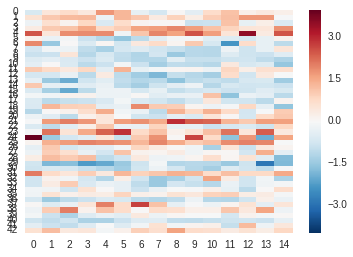

In [537]:
from sklearn.svm import SVC,SVR
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import seaborn as sns

X=zscore(cleanDat,axis=0)
y=np.zeros((len(total),))
y[0:len(top)]=[1]*len(top)

svm = SVC(kernel='linear')
# svm = LogisticRegression(penalty='l2',C=0.0001)
cv = StratifiedKFold(5)


anova = SelectKBest(k=7)
   
# clf = Pipeline([('anova', anova), ('svm', svm)])
clf=svm
score, permutation_scores, pvalue = permutation_test_score(
    clf, X, y, scoring="roc_auc", cv=cv, n_permutations=1000, n_jobs=1)


plt.figure()
sns.heatmap(X)
# print y

print 'now running to get classifier weights'
coefs_=[]
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svm.fit(X_train,y_train)
    coefs_.append(svm.coef_)


Classification score 0.476666666667 (pvalue : 0.575424575425)


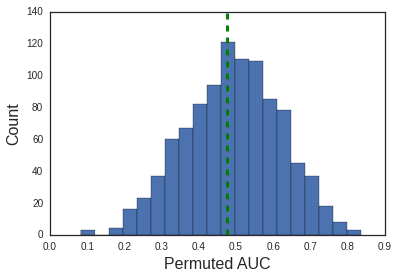

In [538]:
print("Classification score %s (pvalue : %s)" % (score, pvalue))
plt.hist(permutation_scores,20)
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.xlabel('Permuted AUC',fontsize=16)
plt.ylabel('Count',fontsize=16)

In [64]:
import matplotlib as mpl

In [65]:
suffix='cope1'
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000-subjperf-15//cope1_age_gender/'
image_lh=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope1',vmax=8,threshold=0.9499,filename='lh-FB_FvW-subj-perf-15',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope1',vmax=8,threshold=0.9499,filename='rh-FB_FvW-subj-perf-15',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)

suffix='cope1'
folder_nfb='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000-subjperf-15//cope1_age_gender/'
image_lh_nfb=CCD_packages.make_pysurfer_images_lh_rh(folder_nfb,suffix='cope1',vmax=8,threshold=0.9499,filename='lh-NFB_FvW-subj-perf-15',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh_nfb=CCD_packages.make_pysurfer_images_lh_rh(folder_nfb,suffix='cope1',vmax=8,threshold=0.9499,filename='rh-NFB_FvW-subj-perf-15',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)

mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000-subjperf-15//cope1_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2su_XQYO.mgz


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/mayavi/tools/camera.py:288: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000-subjperf-15//cope1_age_gender//thresholded_posneg.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sJ65SLX.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000-subjperf-15//cope1_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sTdvSEo.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000-subjperf-15//cope1_age_gender//thresholded_posneg.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sgOc0GB.mgz


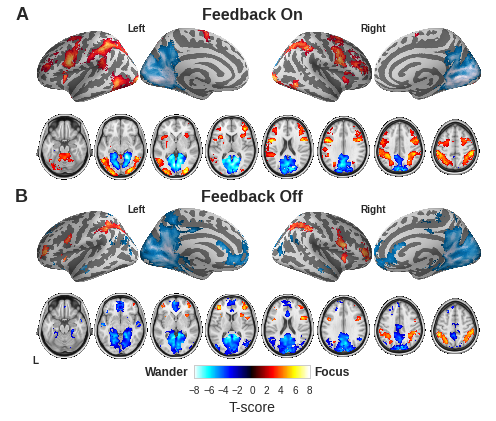

In [66]:
# f, axes = plt.subplots(2,2,figsize=(10,5))
f=plt.figure(figsize=(8,6))
ax1=plt.subplot2grid((4,2),(0,0))
ax2=plt.subplot2grid((4,2),(0,1))
ax3=plt.subplot2grid((4,2),(1,0), colspan=2)
ax4=plt.subplot2grid((4,2),(2,0))
ax5=plt.subplot2grid((4,2),(2,1))
ax6=plt.subplot2grid((4,2),(3,0), colspan=2)


ax1.imshow(image_lh)
ax1.set_xticks(())
ax1.set_yticks(())
ax1.axis('off')
ax2.imshow(image_rh)
ax2.set_xticks(())
ax2.set_yticks(())
ax2.axis('off')
ax3.set_position(matplotlib.transforms.Bbox(array([[0.125,0.45],[0.9,0.8]])))

CCD_packages.createTFCEfMRIOverlayImages(folder,suffix=suffix,slices=range(-20,60,10),vmax=8,plotToAxis=True,f=f,axes=ax3,colorbar=False,annotate=False,tight_layout=False)


ax4.imshow(image_lh_nfb)
ax4.set_xticks(())
ax4.set_yticks(())
ax4.axis('off')
ax5.imshow(image_rh_nfb)
ax5.set_xticks(())
ax5.set_yticks(())
ax5.axis('off')

CCD_packages.createTFCEfMRIOverlayImages(folder_nfb,suffix=suffix,slices=range(-20,60,10),vmax=8,plotToAxis=True,f=f,axes=ax6,colorbar=False,annotate=False,tight_layout=False)


# ax3.set_position([.1,.6,.9,.6])
# ax3.set
plt.figtext(0.1,.93,'A',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.1,.51,'B',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')

cmap=plt.get_cmap('cold_hot')
norm = mpl.colors.Normalize(vmin=-8, vmax=8)


cax=f.add_axes(matplotlib.transforms.Bbox(array([[0.4,0.09],[0.6,0.12]])))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('T-score',fontsize=14)
f.subplots_adjust(wspace=.1,bottom=.1,top=.9)
plt.figtext(0.5,.93,'Feedback On',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')
plt.figtext(0.5,.51,'Feedback Off',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')
# plt.figtext(0.125,.54,'R',horizontalalignment='center',
#         verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.125,.13,'L',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.9,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.48,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.9,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.48,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')

plt.figtext(0.39,.095,'Wander',horizontalalignment='right',
            fontsize=12,figure=f,weight='bold')
plt.figtext(0.61,.095,'Focus',horizontalalignment='left',
        fontsize=12,figure=f,weight='bold')


f.savefig('%s/Focus-versus-Wander-Traditional.png' % CCD_packages.saveFigureLocation,dpi=300)


In [67]:
suffix='cope1'
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000-subjperf-15/Performance/cope1_Performance_age_gender/'
image_lh2=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope1',vmax=8,threshold=0.9499,filename='lh-FB_FvW-subj-perf-15-perf',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh2=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope1',vmax=8,threshold=0.9499,filename='rh-FB_FvW-subj-perf-15-perf',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)

suffix='cope1'
folder_nfb='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000-subjperf-15/Performance/cope1_Performance_age_gender/'
image_lh2_nfb=CCD_packages.make_pysurfer_images_lh_rh(folder_nfb,suffix='cope1',vmax=8,threshold=0.9499,filename='lh-NFB_FvW-subj-perf-15-perf',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh2_nfb=CCD_packages.make_pysurfer_images_lh_rh(folder_nfb,suffix='cope1',vmax=8,threshold=0.9499,filename='rh-NFB_FvW-subj-perf-15-perf',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning:

The given float value must not exceed 0.919907152653. But, you have given threshold=0.9499 



mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000-subjperf-15/Performance/cope1_Performance_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2slXBQwJ.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000-subjperf-15/Performance/cope1_Performance_age_gender//thresholded_posneg.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s8Ujku6.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000-subjperf-15/Performance/cope1_Performance_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s88bawu.mgz
mri_vol2surf --mov /home/jmuraskin/Projec

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning:

The given float value must not exceed 0.919907152653. But, you have given threshold=0.94999 



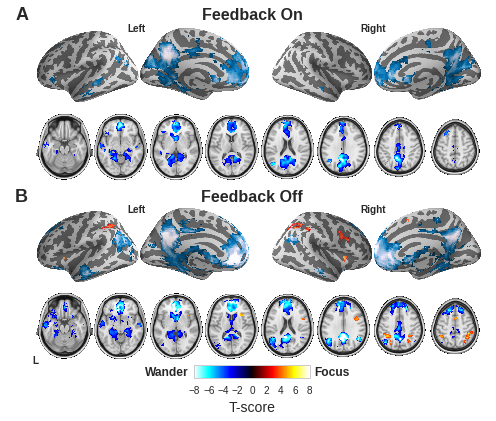

In [68]:
# f, axes = plt.subplots(2,2,figsize=(10,5))
f=plt.figure(figsize=(8,6))
ax1=plt.subplot2grid((4,2),(0,0))
ax2=plt.subplot2grid((4,2),(0,1))
ax3=plt.subplot2grid((4,2),(1,0), colspan=2)
ax4=plt.subplot2grid((4,2),(2,0))
ax5=plt.subplot2grid((4,2),(2,1))
ax6=plt.subplot2grid((4,2),(3,0), colspan=2)


ax1.imshow(image_lh2)
ax1.set_xticks(())
ax1.set_yticks(())
ax1.axis('off')
ax2.imshow(image_rh2)
ax2.set_xticks(())
ax2.set_yticks(())
ax2.axis('off')
ax3.set_position(matplotlib.transforms.Bbox(array([[0.125,0.45],[0.9,0.8]])))

CCD_packages.createTFCEfMRIOverlayImages(folder,suffix=suffix,slices=range(-20,60,10),vmax=8,plotToAxis=True,f=f,axes=ax3,colorbar=False,annotate=False,tight_layout=False)


ax4.imshow(image_lh2_nfb)
ax4.set_xticks(())
ax4.set_yticks(())
ax4.axis('off')
ax5.imshow(image_rh2_nfb)
ax5.set_xticks(())
ax5.set_yticks(())
ax5.axis('off')

CCD_packages.createTFCEfMRIOverlayImages(folder_nfb,suffix=suffix,slices=range(-20,60,10),vmax=8,plotToAxis=True,f=f,axes=ax6,colorbar=False,annotate=False,tight_layout=False)


# ax3.set_position([.1,.6,.9,.6])
# ax3.set
plt.figtext(0.1,.93,'A',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.1,.51,'B',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')

cmap=plt.get_cmap('cold_hot')
norm = mpl.colors.Normalize(vmin=-8, vmax=8)


cax=f.add_axes(matplotlib.transforms.Bbox(array([[0.4,0.09],[0.6,0.12]])))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('T-score',fontsize=14)
f.subplots_adjust(wspace=.1,bottom=.1,top=.9)
plt.figtext(0.5,.93,'Feedback On',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')
plt.figtext(0.5,.51,'Feedback Off',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')
# plt.figtext(0.125,.54,'R',horizontalalignment='center',
#         verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.125,.13,'L',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.9,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.48,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.9,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.48,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.39,.095,'Wander',horizontalalignment='right',
            fontsize=12,figure=f,weight='bold')
plt.figtext(0.61,.095,'Focus',horizontalalignment='left',
        fontsize=12,figure=f,weight='bold')
f.savefig('%s/PerformanceCorrelatesBeta.png' % CCD_packages.saveFigureLocation,dpi=300)



In [69]:
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope1_age_gender/'
image_lh3=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope1',vmax=5,threshold=0.9499,filename='lh-FB-NFB_FvW-subj-perf-15-cope1',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh3=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope1',vmax=5,threshold=0.9499,filename='rh-FB-NFB_FvW-subj-perf-15-cope1',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)

# CCD_packages.make_pysurfer_images(folder,suffix='cope3',threshold=0.9499,filename='Paired-FB-NFB-Focus-subjperf-15',saveFolder=CCD_packages.saveFigureLocation)
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope3_age_gender/'
image_lh4=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope3',vmax=5,threshold=0.9499,filename='lh-FB-NFB_FvW-subj-perf-15-cope3',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh4=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope3',vmax=5,threshold=0.9499,filename='rh-FB-NFB_FvW-subj-perf-15-cope3',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)

folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope4_age_gender/'
image_lh5=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope4',vmax=5,threshold=0.9499,filename='lh-FB-NFB_FvW-subj-perf-15-cope4',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh5=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope4',vmax=5,threshold=0.9499,filename='rh-FB-NFB_FvW-subj-perf-15-cope4',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning:

The given float value must not exceed 0.777699291706. But, you have given threshold=0.9499 



mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope1_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s0GZM7e.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope1_age_gender//thresholded_posneg.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2s51WlML.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope3_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sUMjnvL.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionR

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning:

The given float value must not exceed 0.777699291706. But, you have given threshold=0.94999 



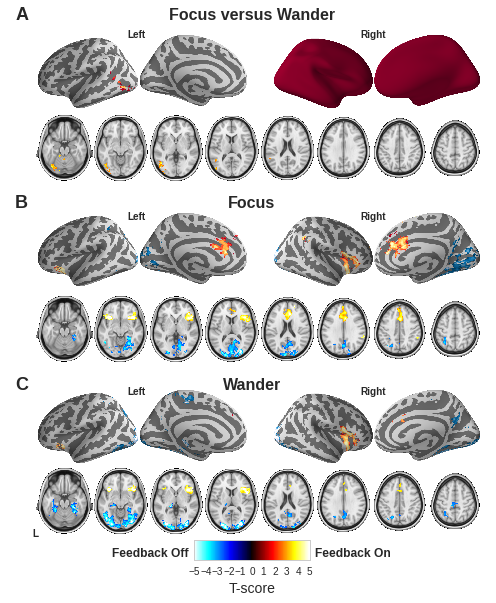

In [70]:
# f, axes = plt.subplots(2,2,figsize=(10,5))
f=plt.figure(figsize=(8,9))
ax1=plt.subplot2grid((6,2),(0,0))
ax2=plt.subplot2grid((6,2),(0,1))
ax3=plt.subplot2grid((6,2),(1,0), colspan=2)
ax4=plt.subplot2grid((6,2),(2,0))
ax5=plt.subplot2grid((6,2),(2,1))
ax6=plt.subplot2grid((6,2),(3,0), colspan=2)
ax7=plt.subplot2grid((6,2),(4,0))
ax8=plt.subplot2grid((6,2),(4,1))
ax9=plt.subplot2grid((6,2),(5,0), colspan=2)


ax1.imshow(image_lh3)
ax1.set_xticks(())
ax1.set_yticks(())
ax1.axis('off')
ax2.imshow(image_rh3)
ax2.set_xticks(())
ax2.set_yticks(())
ax2.axis('off')
ax3.set_position(matplotlib.transforms.Bbox(array([[0.125,0.65],[0.9,0.8]])))

folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope1_age_gender/'
CCD_packages.createTFCEfMRIOverlayImages(folder,suffix='cope1',slices=range(-20,60,10),vmax=5,plotToAxis=True,f=f,axes=ax3,colorbar=False,annotate=False,tight_layout=False)


ax4.imshow(image_lh4)
ax4.set_xticks(())
ax4.set_yticks(())
ax4.axis('off')
ax5.imshow(image_rh4)
ax5.set_xticks(())
ax5.set_yticks(())
ax5.axis('off')
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope3_age_gender/'
CCD_packages.createTFCEfMRIOverlayImages(folder,suffix='cope3',slices=range(-20,60,10),vmax=5,plotToAxis=True,f=f,axes=ax6,colorbar=False,annotate=False,tight_layout=False)


ax7.imshow(image_lh5)
ax7.set_xticks(())
ax7.set_yticks(())
ax7.axis('off')
ax8.imshow(image_rh5)
ax8.set_xticks(())
ax8.set_yticks(())
ax8.axis('off')
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/cope4_age_gender/'
CCD_packages.createTFCEfMRIOverlayImages(folder,suffix='cope4',slices=range(-20,60,10),vmax=5,plotToAxis=True,f=f,axes=ax9,colorbar=False,annotate=False,tight_layout=False)



# ax3.set_position([.1,.6,.9,.6])
# ax3.set
plt.figtext(0.1,.93,'A',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.1,.64,'B',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.1,.36,'C',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')

cmap=plt.get_cmap('cold_hot')
norm = mpl.colors.Normalize(vmin=-5, vmax=5)


cax=f.add_axes(matplotlib.transforms.Bbox(array([[0.4,0.09],[0.6,0.12]])))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('T-score',fontsize=14)
f.subplots_adjust(wspace=.1,bottom=.1,top=.9)
plt.figtext(0.5,.93,'Focus versus Wander',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')
plt.figtext(0.5,.64,'Focus',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')
plt.figtext(0.5,.36,'Wander',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')

# plt.figtext(0.125,.54,'R',horizontalalignment='center',
#         verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.125,.13,'L',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.9,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.62,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.35,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.9,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.62,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.35,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')

plt.figtext(0.39,.095,'Feedback Off',horizontalalignment='right',
            fontsize=12,figure=f,weight='bold')
plt.figtext(0.61,.095,'Feedback On',horizontalalignment='left',
        fontsize=12,figure=f,weight='bold')


f.savefig('%s/FB-versus-NFB-BetaComparisons.png' % CCD_packages.saveFigureLocation,dpi=300)

In [71]:
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/DMN_PC/cope0_age_gender/'
image_lh9=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope0',vmax=5,threshold=0.9499,filename='lh-FB-NFB_DMN-PC-subj-perf-15',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh9=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope0',vmax=5,threshold=0.9499,filename='rh-FB-NFB_DMN-PC-subj-perf-15',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)

# CCD_packages.make_pysurfer_images(folder,suffix='cope3',threshold=0.9499,filename='Paired-FB-NFB-Focus-subjperf-15',saveFolder=CCD_packages.saveFigureLocation)
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/R_AI/cope0_age_gender/'
image_lh10=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope0',vmax=5,threshold=0.9499,filename='lh-FB-NFB_R-AI-subj-perf-15',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh10=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope0',vmax=5,threshold=0.9499,filename='rh-FB-NFB_R-AI-subj-perf-15',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)

folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/ACC/cope0_age_gender/'
image_lh11=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope0',vmax=5,threshold=0.9499,filename='lh-FB-NFB_ACC-subj-perf-15',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)
image_rh11=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope0',vmax=5,threshold=0.9499,filename='rh-FB-NFB_ACC-subj-perf-15',hemi="rh",saveFolder=CCD_packages.saveFigureLocation)


mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/DMN_PC/cope0_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sxAN4FM.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/DMN_PC/cope0_age_gender//thresholded_posneg.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sbCdEtt.mgz


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning:

The given float value must not exceed 0.727603197098. But, you have given threshold=0.9499 



mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/R_AI/cope0_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2syJdMZ4.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/R_AI/cope0_age_gender//thresholded_posneg.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2seD5QAw.mgz


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning:

The given float value must not exceed 0.909503996372. But, you have given threshold=0.9499 



mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/ACC/cope0_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sRMVn99.mgz
mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/ACC/cope0_age_gender//thresholded_posneg.nii.gz --hemi rh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2slxW9kR.mgz


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning:

The given float value must not exceed 0.727603197098. But, you have given threshold=0.94999 

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/nilearn/_utils/param_validation.py:61: UserWarning:

The given float value must not exceed 0.909503996372. But, you have given threshold=0.94999 



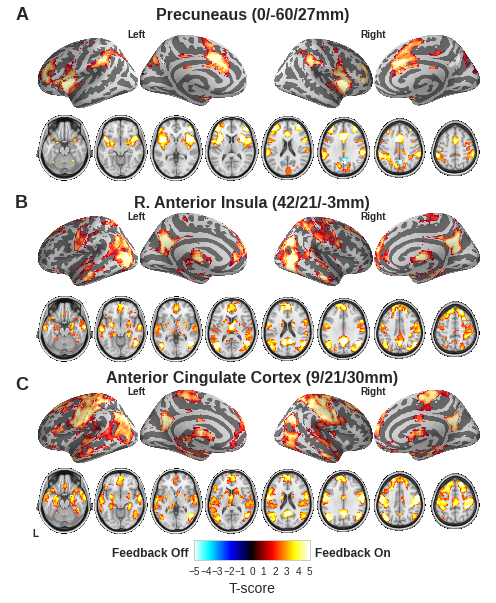

In [72]:
# f, axes = plt.subplots(2,2,figsize=(10,5))
f=plt.figure(figsize=(8,9))
ax1=plt.subplot2grid((6,2),(0,0))
ax2=plt.subplot2grid((6,2),(0,1))
ax3=plt.subplot2grid((6,2),(1,0), colspan=2)
ax4=plt.subplot2grid((6,2),(2,0))
ax5=plt.subplot2grid((6,2),(2,1))
ax6=plt.subplot2grid((6,2),(3,0), colspan=2)
ax7=plt.subplot2grid((6,2),(4,0))
ax8=plt.subplot2grid((6,2),(4,1))
ax9=plt.subplot2grid((6,2),(5,0), colspan=2)


ax1.imshow(image_lh9)
ax1.set_xticks(())
ax1.set_yticks(())
ax1.axis('off')
ax2.imshow(image_rh9)
ax2.set_xticks(())
ax2.set_yticks(())
ax2.axis('off')
ax3.set_position(matplotlib.transforms.Bbox(array([[0.125,0.65],[0.9,0.8]])))

folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/DMN_PC/cope0_age_gender/'
CCD_packages.createTFCEfMRIOverlayImages(folder,suffix='cope0',slices=range(-20,60,10),vmax=5,plotToAxis=True,f=f,axes=ax3,colorbar=False,annotate=False,tight_layout=False)


ax4.imshow(image_lh10)
ax4.set_xticks(())
ax4.set_yticks(())
ax4.axis('off')
ax5.imshow(image_rh10)
ax5.set_xticks(())
ax5.set_yticks(())
ax5.axis('off')
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/R_AI/cope0_age_gender/'
CCD_packages.createTFCEfMRIOverlayImages(folder,suffix='cope0',slices=range(-20,60,10),vmax=5,plotToAxis=True,f=f,axes=ax6,colorbar=False,annotate=False,tight_layout=False)


ax7.imshow(image_lh11)
ax7.set_xticks(())
ax7.set_yticks(())
ax7.axis('off')
ax8.imshow(image_rh11)
ax8.set_xticks(())
ax8.set_yticks(())
ax8.axis('off')
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/ACC/cope0_age_gender/'
CCD_packages.createTFCEfMRIOverlayImages(folder,suffix='cope0',slices=range(-20,60,10),vmax=5,plotToAxis=True,f=f,axes=ax9,colorbar=False,annotate=False,tight_layout=False)



# ax3.set_position([.1,.6,.9,.6])
# ax3.set
plt.figtext(0.1,.93,'A',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.1,.64,'B',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.1,.36,'C',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')

cmap=plt.get_cmap('cold_hot')
norm = mpl.colors.Normalize(vmin=-5, vmax=5)


cax=f.add_axes(matplotlib.transforms.Bbox(array([[0.4,0.09],[0.6,0.12]])))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('T-score',fontsize=14)
f.subplots_adjust(wspace=.1,bottom=.1,top=.9)
plt.figtext(0.5,.93,'Precuneaus (0/-60/27mm)',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')
plt.figtext(0.5,.64,'R. Anterior Insula (42/21/-3mm)',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')
plt.figtext(0.5,.37,'Anterior Cingulate Cortex (9/21/30mm)',horizontalalignment='center',
        verticalalignment='center',fontsize=16,figure=f,weight='bold')

# plt.figtext(0.125,.54,'R',horizontalalignment='center',
#         verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.125,.13,'L',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.9,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.62,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.3,.35,'Left',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.9,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.62,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')
plt.figtext(0.71,.35,'Right',horizontalalignment='center',
        verticalalignment='center',fontsize=10,figure=f,weight='bold')

plt.figtext(0.39,.095,'Feedback Off',horizontalalignment='right',
            fontsize=12,figure=f,weight='bold')
plt.figtext(0.61,.095,'Feedback On',horizontalalignment='left',
        fontsize=12,figure=f,weight='bold')


f.savefig('%s/FunctionalConnectivityDifferences.png' % CCD_packages.saveFigureLocation,dpi=300)

mri_vol2surf --mov /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/ACC/Performance/cope0_Performance_age_gender//thresholded_posneg.nii.gz --hemi lh --surf white --reg /opt/freesurfer/average/mni152.register.dat --projfrac-avg 0 1 0.1 --o /tmp/pysurfer-v2sZcWono.mgz
[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]    0.1s, 0.0min: Loading resample_img...
[Memory]    0.1s, 0.0min: Loading filter_and_mask...


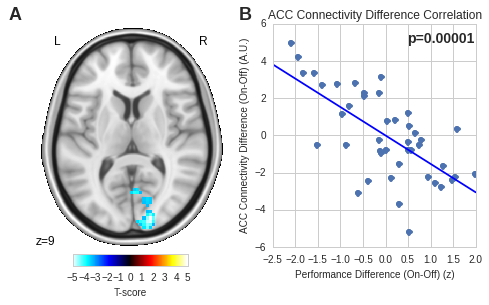

In [123]:
from nilearn import input_data
import os

f,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/ACC/Performance/cope0_Performance_age_gender/'
# folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/DMN_PC/cope0_age_gender/'
image_lh12=CCD_packages.make_pysurfer_images_lh_rh(folder,suffix='cope0',vmax=5,threshold=0.9499,filename='lh-FB-NFB_ACC-perf-subj-perf-15',hemi="lh",saveFolder=CCD_packages.saveFigureLocation)

CCD_packages.createTFCEfMRIOverlayImages(folder,suffix='cope0',slices=[9],vmax=5,annotate=True,tight_layout=False,plotToAxis=True,f=f,axes=ax1,colorbar=False)



os.system('fslmaths %s/thresholded_posneg.nii.gz -mul -1 -bin %s/threshold_mask' % (folder,folder))

# Extracting signal from sphere around DMN seeds
masker = input_data.NiftiMasker(mask_img='%s/threshold_mask.nii.gz' % folder,
    mask_strategy='background',
    detrend=False, standardize=False, memory='nilearn_cache', 
    memory_level=1, verbose=2)

# fb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
# nofb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
masker.fit()
bold_signal = masker.transform('%s/cope0_merged.nii.gz' % folder)

design=read_csv('%s/design.mat' % folder,delim_whitespace=True,header=3,names=['confound1','confound2','confound3', 'Performance Difference'])
results=CCD_packages.runRLMR(bold_signal.mean(axis=1),design,['confound1','confound2','confound3', 'Performance Difference'],RLM=False,plotFigure=False)

sm.graphics.plot_ccpr(results, 'Performance Difference',ax=ax2)
sns.set_style("whitegrid")
ax2.annotate('p=%0.5f' % (results.pvalues['Performance Difference']),xy=(.5,5),fontsize=14,weight='semibold')
ax2.set_xlabel('Performance Difference (On-Off) (z)',fontsize=10)
ax2.set_ylabel('ACC Connectivity Difference (On-Off) (A.U.)',fontsize=10)
ax2.set_title('ACC Connectivity Difference Correlation')

cmap=plt.get_cmap('cold_hot')
norm = mpl.colors.Normalize(vmin=-5, vmax=5)


cax=f.add_axes(matplotlib.transforms.Bbox(array([[0.2,0.06],[0.4,0.1]])))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('T-score',fontsize=10)
plt.figtext(0.1,.93,'A',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.5,.93,'B',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')

f.savefig('%s/ACC_Connectivity_difference.png' % CCD_packages.saveFigureLocation,dpi=300)
# bold_signal.mean(axis=1)

[Memory]    0.0s, 0.0min: Loading filter_and_extract...


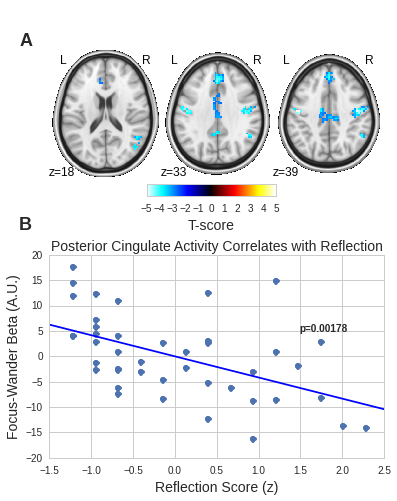

In [78]:
from nilearn import input_data
import os

f,(ax1,ax2) = plt.subplots(2,1,figsize=(6,8))

folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000-subjperf-15/V1_CCDRSQ_75/cope1_V1_CCDRSQ_75_age_gender/'
CCD_packages.createTFCEfMRIOverlayImages(folder,suffix='cope1',slices=[18,33,39],vmax=5,annotate=True,tight_layout=False,plotToAxis=True,f=f,axes=ax1,colorbar=False)

cmap=plt.get_cmap('cold_hot')
norm = mpl.colors.Normalize(vmin=-5, vmax=5)


cax=f.add_axes(matplotlib.transforms.Bbox(array([[0.35,0.58],[0.65,0.6]])))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('T-score',fontsize=14)

os.system('fslmaths %s/thresholded_posneg.nii.gz -mul -1 -bin %s/threshold_mask' % (folder,folder))



# # Extracting signal from sphere around DMN seeds
roi_coords = [(9, -24, 42)]
# labels = [
#     'Left Thalamus',
#     'Anterior Cingulate Gyrus',
#     'Left Lateral Occipital Cortex',
#     'Left Posterior Cingulate'
# ]

# # Extracting signal from sphere around DMN seeds
masker = input_data.NiftiSpheresMasker(
    roi_coords, radius=6,
    detrend=False, standardize=False, memory='nilearn_cache', 
    memory_level=1, verbose=2)

# masker = input_data.NiftiLabelsMasker(labels_img='%s/cope1_thresh2_cluster.nii.gz' % folder,
#     detrend=False, standardize=False, memory='nilearn_cache', 
#     memory_level=1, verbose=2)

# fb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
# nofb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
# masker.fit()
bold_signal = masker.fit_transform('%s/cope1_merged.nii.gz' % folder)

design=read_csv('%s/design.mat' % folder,delim_whitespace=True,header=3,names=['confound1','confound2','confound3', 'Performance Difference'])
results=CCD_packages.runRLMR(bold_signal[:,0],design,['confound1','confound2','confound3', 'Performance Difference'],RLM=False,plotFigure=False)

sm.graphics.plot_ccpr(results, 'Performance Difference',ax=ax2)
sns.set_style("whitegrid")
ax2.annotate('p=%0.5f' % (results.pvalues['Performance Difference']),xy=(1.5,5),fontsize=10,weight='semibold')
ax2.set_xlabel('Reflection Score (z)',fontsize=14)
ax2.set_ylabel('Focus-Wander Beta (A.U.)',fontsize=14)
ax2.set_title('Posterior Cingulate Activity Correlates with Reflection',fontsize=14)

plt.figtext(0.07,.85,'A',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.07,.53,'B',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')

f.savefig('%s/Reflection_correlation.png' % CCD_packages.saveFigureLocation,dpi=300)

# bold_signal.mean(axis=1)

[NiftiLabelsMasker.fit_transform] loading data from /home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/train/motionRMS-1.000000-subjperf-15/ACC/Performance/FEEDBACK/cope0_Performance_age_gender/cluster_mask_cope0_zstat1_thresh.nii.gz
[Memory]    0.0s, 0.0min: Loading filter_and_extract...


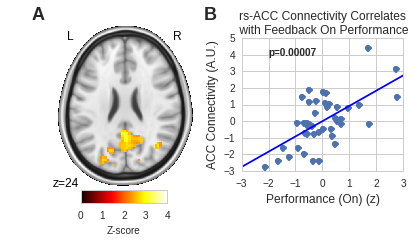

In [143]:
from nilearn import image,plotting
bg_img='./Templates/MNI152_.5mm_masked_edged.nii.gz'
folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/train/motionRMS-1.000000-subjperf-15/ACC/Performance/FEEDBACK/cope0_Performance_age_gender'

fw='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/train/motionRMS-1.000000-subjperf-15/ACC/Performance/FEEDBACK/cope0_Performance_age_gender/thresh_cope0_zstat1_thresh.nii.gz'

# threshold=0.949
# pos=image.math_img("np.multiply(img1,img2)",
#                      img1=image.threshold_img(TFCEposImg,threshold=threshold),img2=posImg)
# neg=image.math_img("np.multiply(img1,img2)",
#                      img1=image.threshold_img(TFCEnegImg,threshold=threshold),img2=negImg)
# fw=image.math_img("img1-img2",img1=pos,img2=neg)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
plotting.plot_stat_map(fw,bg_img=bg_img,display_mode='z',cut_coords=[24],draw_cross=False,
                       black_bg=False,dim=0,figure=f,axes=ax1,colorbar=False)

masker = input_data.NiftiLabelsMasker(labels_img='%s/cluster_mask_cope0_zstat1_thresh.nii.gz' % folder,
    detrend=False, standardize=False, memory='nilearn_cache', 
    memory_level=1, verbose=2)

# fb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
# nofb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
# masker.fit()
bold_signal = masker.fit_transform('%s/cope0_merged.nii.gz' % folder)

design=read_csv('%s/design.mat' % folder,delim_whitespace=True,header=3,names=['confound1','confound2','confound3', 'Performance Difference'])
results=CCD_packages.runRLMR(bold_signal[:,0],design,['confound1','confound2','confound3', 'Performance Difference'],RLM=False,plotFigure=False)

sm.graphics.plot_ccpr(results, 'Performance Difference',ax=ax2)
sns.set_style("whitegrid")
ax2.annotate('p=%0.5f' % (results.pvalues['Performance Difference']),xy=(-2,4),fontsize=10,weight='semibold')
ax2.set_xlabel('Performance (On) (z)',fontsize=12)
ax2.set_ylabel('ACC Connectivity (A.U.)',fontsize=12)
ax2.set_title('rs-ACC Connectivity Correlates\n with Feedback On Performance',fontsize=12,multialignment='center')
# if plotToAxis:
#     display=plotting.plot_stat_map(fw,display_mode=display_mode,threshold=0,
#                                    cut_coords=slices,vmax=vmax,colorbar=colorbar,
#                                    bg_img=bg_img,black_bg=False,title=title,dim=0,
#                                    figure=f,axes=axes,draw_cross=draw_cross,
#                                    annotate=annotate)
# else:
#     display=plotting.plot_stat_map(fw,display_mode=display_mode,threshold=0,
#     cut_coords=slices,vmax=vmax,colorbar=colorbar,bg_img=bg_img,
#     black_bg=False,title=title,dim=0,annotate=annotate)
plt.figtext(0.1,.93,'A',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
plt.figtext(0.5,.93,'B',horizontalalignment='center',
        verticalalignment='center',fontsize=18,figure=f,weight='bold')
cmap=plt.get_cmap('hot')
norm = mpl.colors.Normalize(vmin=0, vmax=4)


cax=f.add_axes(matplotlib.transforms.Bbox(array([[0.2,0.06],[0.4,0.12]])))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_ticks(range(0,5),range(0,5))
cb1.set_label('Z-score',fontsize=10)
f.tight_layout()
f.savefig('%s/rsACC-FB_Performance.png' % CCD_packages.saveFigureLocation)

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



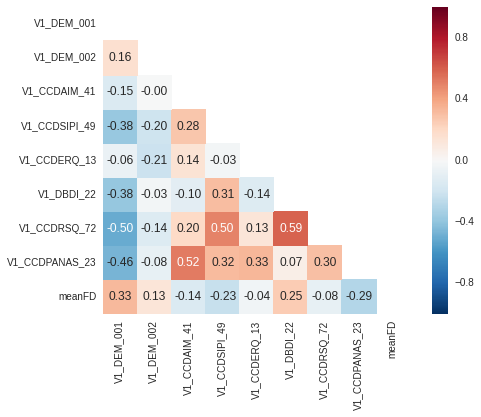

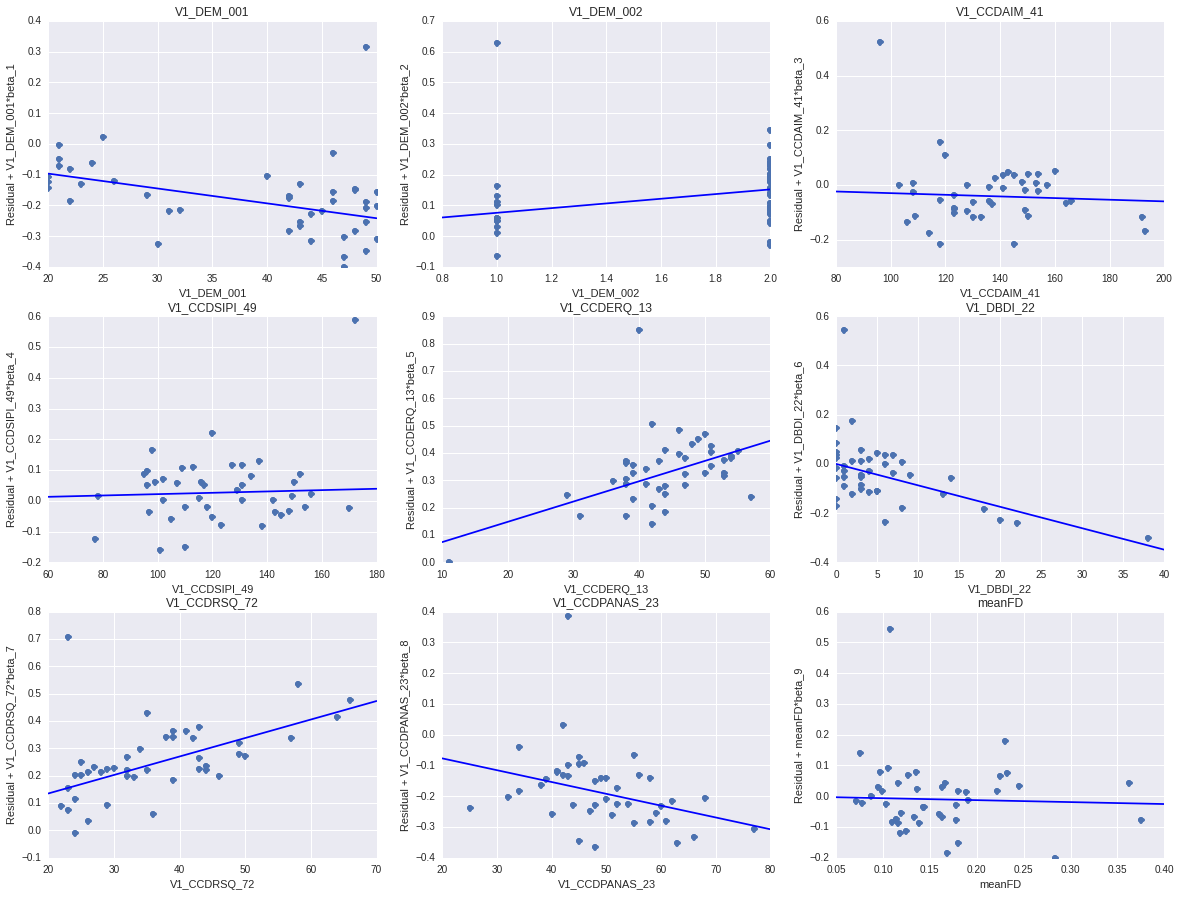

In [14]:
from pandas import read_csv
# import seaborn as sns

#phenotypic info
phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'

pheno=read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)
subject_list=goodsubj

addmotion=True
addNOFB=False
addScanOrder=False


phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
# phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDAIM_41','V1_CCDERQ_13','V1_CCDRSQ_72']


modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
if addmotion:
    
    pheno=pheno.loc[subject_list][phenoValues]
    phenoValues+=['meanFD']
    pheno['meanFD']=motionInfo
    modelX=pheno
else:
    modelX=pheno.loc[subject_list][phenoValues]

if addNOFB:
    phenoValues+=['NOFB']
    modelX['NOFB']=NOFB

if addScanOrder:
    phenoValues+=['scanorder']
    pheno['scanorder']=scanorder
inputs=modelInfo
# inputs=array(fb_performance['R'])
# inputs=array(fb_coefs[fb_coefs.pe==3]['Coef'])
corr = modelX.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True,annot=True, fmt="0.2f")
results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,figsize=(20,15))




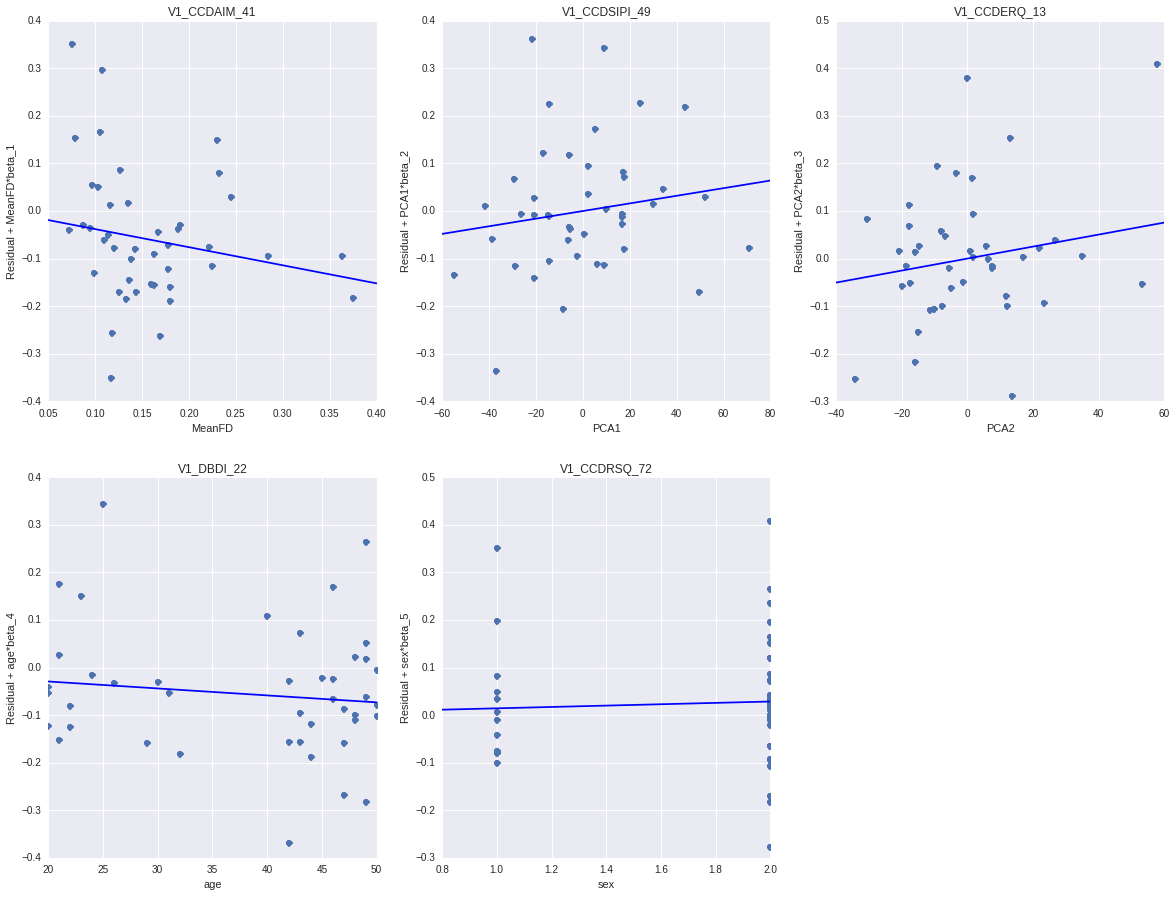

In [5]:
from sklearn import decomposition
from pandas import read_csv,DataFrame

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'

pheno=read_csv(phenoFile)
pheno=pheno.set_index('participant').fillna(value=0)
subject_list=goodsubj

addmotion=True
addNOFB=False
addScanOrder=False


phenoValues=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
# phenoValues=['V1_DEM_001','V1_DEM_002','V1_CCDAIM_41','V1_CCDERQ_13','V1_CCDRSQ_72']


modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])

    
X_full=pheno.loc[subject_list][phenoValues]

pca = decomposition.PCA(svd_solver='full', n_components='mle')
pca.fit(X_full.values)
X = pca.transform(X_full.values)

model=DataFrame({'PCA1':X[:,0],'PCA2':X[:,1],'MeanFD':motionInfo,'age':pheno.loc[subject_list]['V1_DEM_001'],'sex':pheno.loc[subject_list]['V1_DEM_002']},index=subject_list)

results=CCD_packages.runRLMR(modelInfo,model,phenoValues,RLM=True,figsize=(20,15))


Feedback: 0 -- Pheno: AIM -- P-Value: 0.587
Feedback: 1 -- Pheno: AIM -- P-Value: 0.892
Feedback: 0 -- Pheno: SIPI -- P-Value: 0.131
Feedback: 1 -- Pheno: SIPI -- P-Value: 0.178
Feedback: 0 -- Pheno: ERQ -- P-Value: 0.084
Feedback: 1 -- Pheno: ERQ -- P-Value: 0.000
Feedback: 0 -- Pheno: DBDI -- P-Value: 0.193
Feedback: 1 -- Pheno: DBDI -- P-Value: 0.361
Feedback: 0 -- Pheno: RSQ -- P-Value: 0.138
Feedback: 1 -- Pheno: RSQ -- P-Value: 0.018
Feedback: 0 -- Pheno: PANAS -- P-Value: 0.308
Feedback: 1 -- Pheno: PANAS -- P-Value: 0.546


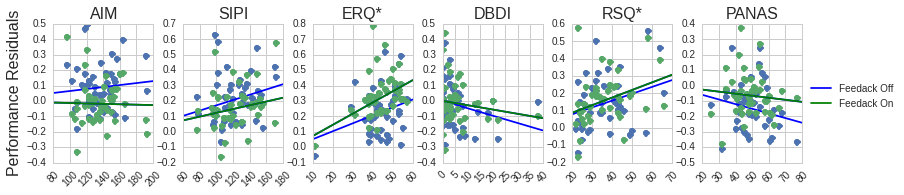

In [35]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']
fig, axes = plt.subplots(1,6,figsize=(13, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'
pvals=[]

for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
            modelX=pheno

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder

        if fb:
            inputs=modelInfo
        else:
            inputs=NOFB
            
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
        pvals.append(results.pvalues[phenoV])
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='AIM':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='PANAS':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.13,top=.9,left=.1,right=.9)
fig.savefig('%s/Total_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



In [38]:
from mne.stats import fdr_correction

nfbP=pvals[::2]
fbP=pvals[1::2]

pfdrT=fdr_correction(fbP)
print pfdrT

(array([False, False,  True, False, False, False], dtype=bool), array([ 0.89186241,  0.35667329,  0.00276613,  0.54104941,  0.05489903,
        0.65571025]))


Feedback: 0 -- Pheno: Reappraisal -- P-Value: 0.105
Feedback: 1 -- Pheno: Reappraisal -- P-Value: 0.007
Feedback: 0 -- Pheno: Suppression -- P-Value: 0.715
Feedback: 1 -- Pheno: Suppression -- P-Value: 0.246
Feedback: 0 -- Pheno: Brooding -- P-Value: 0.257
Feedback: 1 -- Pheno: Brooding -- P-Value: 0.011
Feedback: 0 -- Pheno: Depression -- P-Value: 0.365
Feedback: 1 -- Pheno: Depression -- P-Value: 0.257
Feedback: 0 -- Pheno: Reflection -- P-Value: 0.091
Feedback: 1 -- Pheno: Reflection -- P-Value: 0.012


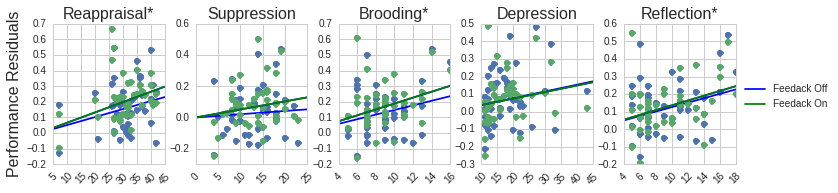

In [248]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDERQ_11','V1_CCDERQ_12','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75']
phenoNames=['Reappraisal','Suppression','Brooding','Depression','Reflection']
fig, axes = plt.subplots(1,5,figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
            modelX=pheno

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder

        if fb:
            inputs=modelInfo
        else:
            inputs=NOFB
            
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='Reappraisal':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='Reflection':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.28,bottom=.12,top=.9,left=.07,right=.86)
fig.savefig('%s/Sub_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



In [52]:
fw_spatial=read_csv('Focus-Wander-SpatialROI.csv').drop('Unnamed: 0',axis=1)
fw_spatial=fw_spatial.groupby(['Subject','cope','fb'])['signal'].mean()

In [41]:
import statsmodels.api as sm
import pandas as pd

highPassCutOff=.25
addBias=1



SubjectDF = GroupDF[GroupDF.Subject_ID.isin(goodsubj)].groupby(['Subject_ID','FB','TR'])['RSN3','flip','modelcorr'].mean()


count=0
for indx,subj in enumerate(goodsubj):
    
    for feedback in ['FEEDBACK','NOFEEDBACK']:
        y = SubjectDF.loc[subj,feedback,:]['RSN3']
        flip = SubjectDF.loc[subj,feedback,:]['flip'].mean()
        y*=flip
        
        modelX=np.column_stack([wander_convolved,-1*focus_convolved])

            
        if addBias:
            modelX=sm.add_constant(modelX)
        model = sm.RLM(y, modelX)
        results = model.fit()
        
        if flip==1:
            df=DataFrame({'Wander':results.params['x1'],'Focus':results.params['x2'],'WanderP':results.pvalues['x1'],'FocusP':results.pvalues['x2'],'results':results,'fb':feedback},index=[subj])
        else:
            df=DataFrame({'Wander':results.params['x2'],'Focus':results.params['x1'],'WanderP':results.pvalues['x2'],'FocusP':results.pvalues['x1'],'results':results,'fb':feedback},index=[subj])
        
        if count==0:
            groupResults=df
        else:
            groupResults=pd.concat((groupResults,df))
        count+=1

NameError: name 'DataFrame' is not defined

In [54]:
groupResults['Subjects']=groupResults.index[:]

NameError: name 'groupResults' is not defined

In [53]:
plt.figure()
sns.factorplot(x='fb',y='Focus',data=groupResults,units='Subjects',kind='bar',ci=68)

plt.figure()
sns.factorplot(x='fb',y='Wander',data=groupResults,units='Subjects',kind='bar',ci=68)

# plt.figure()
# sns.factorplot(x='fb',y='Wander',data=groupResults,units='Subjects',kind='bar',ci=68)
print ttest_1samp(groupResults[groupResults['fb']=='FEEDBACK']['Focus'].values-groupResults[groupResults['fb']=='NOFEEDBACK']['Focus'].values,0)
print ttest_1samp(groupResults[groupResults['fb']=='FEEDBACK']['Wander'].values-groupResults[groupResults['fb']=='NOFEEDBACK']['Wander'].values,0)

NameError: name 'groupResults' is not defined

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



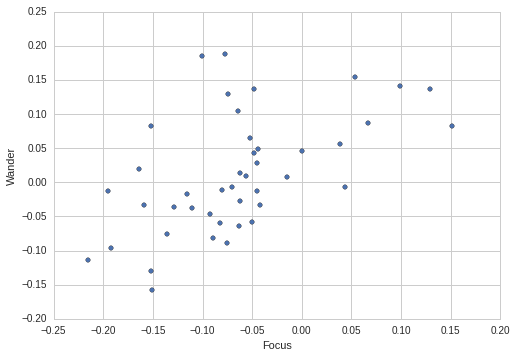

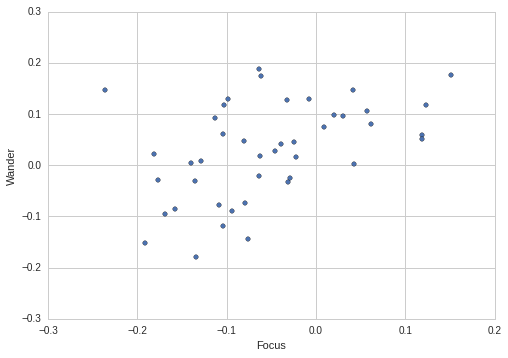

In [26]:
groupResults[groupResults['fb']=='FEEDBACK'].plot(x='Focus',y='Wander',kind='scatter')
groupResults[groupResults['fb']=='NOFEEDBACK'].plot(x='Focus',y='Wander',kind='scatter')

(0.81774814559705344, 2.1858639067370383e-11)


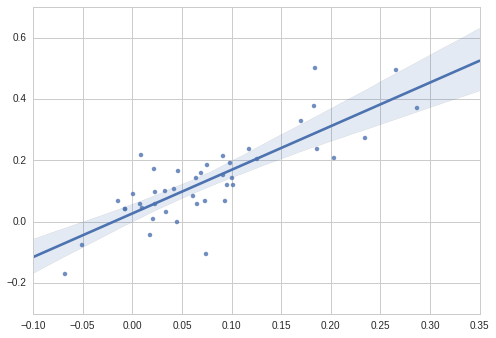

In [28]:
sns.regplot(x=groupResults[groupResults['fb']=='FEEDBACK']['Wander'].values-groupResults[groupResults['fb']=='FEEDBACK']['Focus'].values,y=SubjectDF.loc[goodsubj,'FEEDBACK',[0]]['modelcorr'].values)
print pearsonr(groupResults[groupResults['fb']=='FEEDBACK']['Wander'].values-groupResults[groupResults['fb']=='FEEDBACK']['Focus'].values,SubjectDF.loc[goodsubj,'FEEDBACK',[0]]['modelcorr'].values)

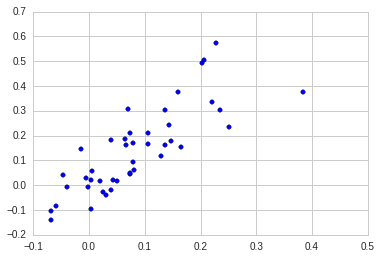

In [225]:
plt.scatter(groupResults[groupResults['fb']=='NOFEEDBACK']['Wander'].values-groupResults[groupResults['fb']=='NOFEEDBACK']['Focus'].values,SubjectDF.loc[goodsubj,'NOFEEDBACK',[0]]['modelcorr'].values)

Feedback: 0 -- Pheno: AIM -- P-Value: 0.645
Feedback: 1 -- Pheno: AIM -- P-Value: 0.122
Feedback: 0 -- Pheno: SIPI -- P-Value: 0.069
Feedback: 1 -- Pheno: SIPI -- P-Value: 0.500
Feedback: 0 -- Pheno: ERQ -- P-Value: 0.328
Feedback: 1 -- Pheno: ERQ -- P-Value: 0.176
Feedback: 0 -- Pheno: DBDI -- P-Value: 0.556
Feedback: 1 -- Pheno: DBDI -- P-Value: 0.911
Feedback: 0 -- Pheno: RSQ -- P-Value: 0.264
Feedback: 1 -- Pheno: RSQ -- P-Value: 0.115
Feedback: 0 -- Pheno: PANAS -- P-Value: 0.927
Feedback: 1 -- Pheno: PANAS -- P-Value: 0.021


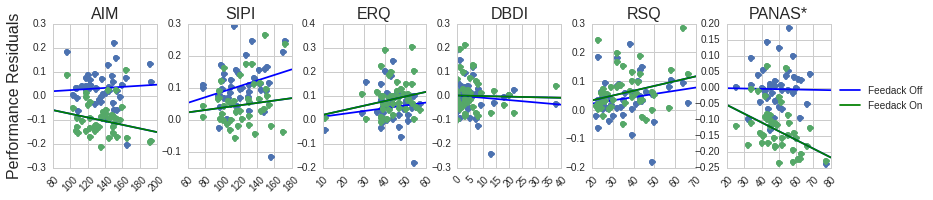

In [34]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']
fig, axes = plt.subplots(1,6,figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False
        addFocus=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
            

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder
        
        if addFocus:
            if fb:
                pheno['focus']= groupResults[groupResults['fb']=='FEEDBACK']['Focus'].values
            else:
                pheno['focus']= groupResults[groupResults['fb']=='NOFEEDBACK']['Focus'].values
        if fb:
            inputs=groupResults[groupResults['fb']=='FEEDBACK']['Wander'].values
        else:
            inputs=groupResults[groupResults['fb']=='NOFEEDBACK']['Wander'].values
        modelX=pheno  
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='AIM':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='PANAS':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.05,right=.95)
fig.savefig('%s/Wander_Total_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



NameError: name 'groupResults' is not defined

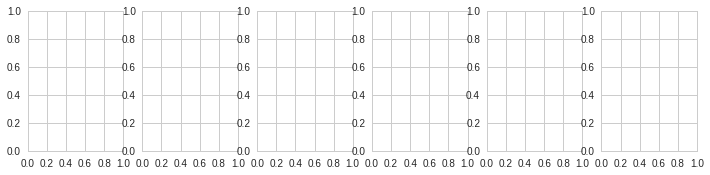

In [40]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']
fig, axes = plt.subplots(1,6,figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False
        addWander=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
            

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder
        
        if addWander:
            if fb:
                pheno['Wander']=groupResults[groupResults['fb']=='FEEDBACK']['Wander'].values
            else:
                pheno['Wander']=groupResults[groupResults['fb']=='NOFEEDBACK']['Wander'].values
        if fb:
            inputs=groupResults[groupResults['fb']=='FEEDBACK']['Focus'].values
        else:
            inputs=groupResults[groupResults['fb']=='NOFEEDBACK']['Focus'].values
        
        modelX=pheno
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='AIM':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='PANAS':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.05,right=.95)
fig.savefig('%s/Focus_Total_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



Feedback: 0 -- Pheno: Reappraisal -- P-Value: 0.135
Feedback: 1 -- Pheno: Reappraisal -- P-Value: 0.005
Feedback: 0 -- Pheno: Suppression -- P-Value: 0.432
Feedback: 1 -- Pheno: Suppression -- P-Value: 0.333
Feedback: 0 -- Pheno: Brooding -- P-Value: 0.289
Feedback: 1 -- Pheno: Brooding -- P-Value: 0.849
Feedback: 0 -- Pheno: Depression -- P-Value: 0.142
Feedback: 1 -- Pheno: Depression -- P-Value: 0.089
Feedback: 0 -- Pheno: Reflection -- P-Value: 0.004
Feedback: 1 -- Pheno: Reflection -- P-Value: 0.428


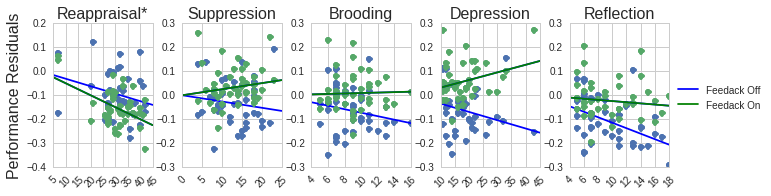

In [230]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDERQ_11','V1_CCDERQ_12','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75']
phenoNames=['Reappraisal','Suppression','Brooding','Depression','Reflection',]
fig, axes = plt.subplots(1,5,figsize=(9.5, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False
        addFocus=True



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
            modelX=pheno

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder

        if fb:
            inputs=groupResults[groupResults['fb']=='FEEDBACK']['Focus'].values
        else:
            inputs=groupResults[groupResults['fb']=='NOFEEDBACK']['Focus'].values
            
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='Reappraisal':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='Reflection':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.05,right=.95)
fig.savefig('%s/Focus_Sub_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



Feedback: 0 -- Pheno: Reappraisal -- P-Value: 0.135
Feedback: 1 -- Pheno: Reappraisal -- P-Value: 0.005
Feedback: 0 -- Pheno: Suppression -- P-Value: 0.432
Feedback: 1 -- Pheno: Suppression -- P-Value: 0.333
Feedback: 0 -- Pheno: Brooding -- P-Value: 0.289
Feedback: 1 -- Pheno: Brooding -- P-Value: 0.849
Feedback: 0 -- Pheno: Depression -- P-Value: 0.142
Feedback: 1 -- Pheno: Depression -- P-Value: 0.089
Feedback: 0 -- Pheno: Reflection -- P-Value: 0.004
Feedback: 1 -- Pheno: Reflection -- P-Value: 0.428


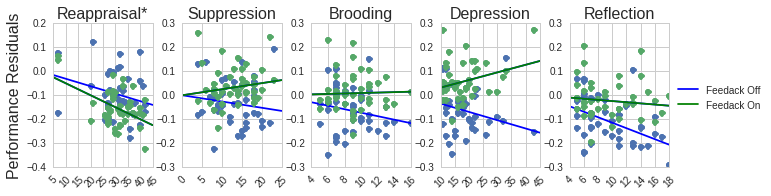

In [231]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDERQ_11','V1_CCDERQ_12','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75']
phenoNames=['Reappraisal','Suppression','Brooding','Depression','Reflection',]
fig, axes = plt.subplots(1,5,figsize=(9.5, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
            modelX=pheno

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder

        if fb:
            inputs=groupResults[groupResults['fb']=='FEEDBACK']['Focus'].values
        else:
            inputs=groupResults[groupResults['fb']=='NOFEEDBACK']['Focus'].values
            
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='Reappraisal':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='Reflection':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.05,right=.95)
fig.savefig('%s/Wander_Sub_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



Feedback: 0 -- Pheno: AIM -- P-Value: 0.354
Feedback: 1 -- Pheno: AIM -- P-Value: 0.491
Feedback: 0 -- Pheno: SIPI -- P-Value: 0.505
Feedback: 1 -- Pheno: SIPI -- P-Value: 0.159
Feedback: 0 -- Pheno: ERQ -- P-Value: 0.819
Feedback: 1 -- Pheno: ERQ -- P-Value: 0.026
Feedback: 0 -- Pheno: DBDI -- P-Value: 0.457
Feedback: 1 -- Pheno: DBDI -- P-Value: 0.461
Feedback: 0 -- Pheno: RSQ -- P-Value: 0.930
Feedback: 1 -- Pheno: RSQ -- P-Value: 0.836
Feedback: 0 -- Pheno: PANAS -- P-Value: 0.429
Feedback: 1 -- Pheno: PANAS -- P-Value: 0.641


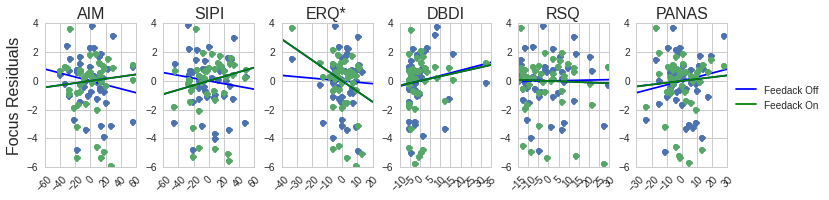

In [61]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']
fig, axes = plt.subplots(1,6,figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False
        addWander=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
#             modelX=pheno

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder
        
        if addWander:
            if fb:
                pheno['Wander']=fw_spatial.loc[goodsubj,[4],'FEEDBACK'].values
            else:
                pheno['Wander']=fw_spatial.loc[goodsubj,[4],'NOFEEDBACK'].values
            
            
        if fb:
            inputs=fw_spatial.loc[goodsubj,[3],'FEEDBACK'].values
        else:
            inputs=fw_spatial.loc[goodsubj,[3],'NOFEEDBACK'].values
        modelX=pheno.sub(pheno.mean())
        
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='AIM':
        ax.set_ylabel('Focus Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='PANAS':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.07,right=.86)
fig.savefig('%s/Focus_Spatial_Total_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



Feedback: 0 -- Pheno: AIM -- P-Value: 0.576
Feedback: 1 -- Pheno: AIM -- P-Value: 0.979
Feedback: 0 -- Pheno: SIPI -- P-Value: 0.685
Feedback: 1 -- Pheno: SIPI -- P-Value: 0.130
Feedback: 0 -- Pheno: ERQ -- P-Value: 0.131
Feedback: 1 -- Pheno: ERQ -- P-Value: 0.964
Feedback: 0 -- Pheno: DBDI -- P-Value: 0.654
Feedback: 1 -- Pheno: DBDI -- P-Value: 0.742
Feedback: 0 -- Pheno: RSQ -- P-Value: 0.755
Feedback: 1 -- Pheno: RSQ -- P-Value: 0.880
Feedback: 0 -- Pheno: PANAS -- P-Value: 0.845
Feedback: 1 -- Pheno: PANAS -- P-Value: 0.680


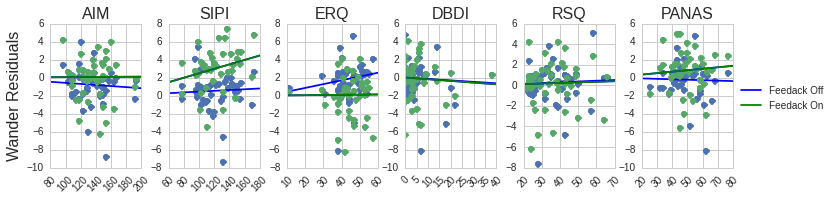

In [56]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']
fig, axes = plt.subplots(1,6,figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False
        addFocus=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
#             modelX=pheno

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder

        if addWander:
            if fb:
                pheno['Focus']=fw_spatial.loc[goodsubj,[3],'FEEDBACK'].values
            else:
                pheno['Focus']=fw_spatial.loc[goodsubj,[3],'NOFEEDBACK'].values    
            
        if fb:
            inputs=fw_spatial.loc[goodsubj,[4],'FEEDBACK'].values
        else:
            inputs=fw_spatial.loc[goodsubj,[4],'NOFEEDBACK'].values
        modelX=pheno    
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='AIM':
        ax.set_ylabel('Wander Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='PANAS':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.07,right=.86)
fig.savefig('%s/Wander_Spatial_Total_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



Feedback: 0 -- Pheno: Reappraisal -- P-Value: 0.781
Feedback: 1 -- Pheno: Reappraisal -- P-Value: 0.843
Feedback: 0 -- Pheno: Suppression -- P-Value: 0.971
Feedback: 1 -- Pheno: Suppression -- P-Value: 0.006


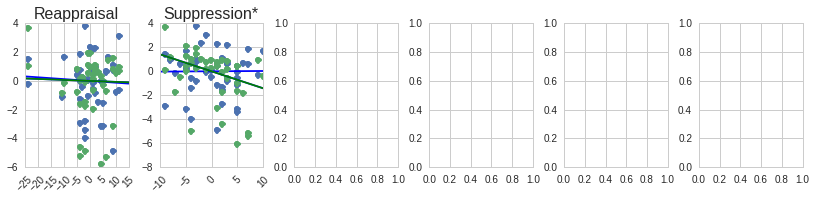

In [ ]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDERQ_11','V1_CCDERQ_12']
phenoNames=['Reappraisal','Suppression']
fig, axes = plt.subplots(1,6,figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=False
        addWander=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
#             modelX=pheno

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder

        if addWander:
            if fb:
                pheno['Focus']=fw_spatial.loc[goodsubj,[4],'FEEDBACK'].values
            else:
                pheno['Focus']=fw_spatial.loc[goodsubj,[4],'NOFEEDBACK'].values    
            
        if fb:
            inputs=fw_spatial.loc[goodsubj,[3],'FEEDBACK'].values
        else:
            inputs=fw_spatial.loc[goodsubj,[3],'NOFEEDBACK'].values
        modelX=pheno.sub(pheno.mean()) 
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='AIM':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='PANAS':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.05,right=.95)
fig.savefig('%s/Focus_Spatial_Sub_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



Feedback: 0 -- Pheno: Reappraisal -- P-Value: 0.794
Feedback: 1 -- Pheno: Reappraisal -- P-Value: 0.868
Feedback: 0 -- Pheno: Suppression -- P-Value: 0.968
Feedback: 1 -- Pheno: Suppression -- P-Value: 0.006
Feedback: 0 -- Pheno: Brooding -- P-Value: 0.833
Feedback: 1 -- Pheno: Brooding -- P-Value: 0.459
Feedback: 0 -- Pheno: Depression -- P-Value: 0.924
Feedback: 1 -- Pheno: Depression -- P-Value: 0.861
Feedback: 0 -- Pheno: Reflection -- P-Value: 0.827
Feedback: 1 -- Pheno: Reflection -- P-Value: 0.970


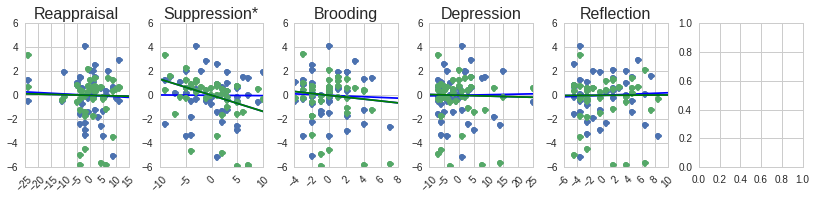

In [63]:
import statsmodels.api as sm
import matplotlib.lines as mlines


phenoValuesTotal=['V1_CCDERQ_11','V1_CCDERQ_12','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75']
phenoNames=['Reappraisal','Suppression','Brooding','Depression','Reflection']
fig, axes = plt.subplots(1,6,figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'


for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
    for fb in [0,1]:
        pheno=read_csv(phenoFile)
        pheno=pheno.set_index('participant').fillna(value=0)
        subject_list=goodsubj

        addmotion=True
        addNOFB=False
        addScanOrder=True
        addWander=False



        phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


        modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
        scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
        NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
        if addmotion:

            pheno=pheno.loc[subject_list][phenoValues]
            phenoValues+=['meanFD']
            if fb:
                pheno['meanFD']=motionInfo
            else:
                pheno['meanFD']=motionInfoNFB               
#             modelX=pheno

        else:
            modelX=pheno.loc[subject_list][phenoValues]

        if addNOFB:
            phenoValues+=['NOFB']
            modelX['NOFB']=NOFB

        if addScanOrder:
            phenoValues+=['scanorder']
            pheno['scanorder']=scanorder

        if addWander:
            if fb:
                pheno['Focus']=fw_spatial.loc[goodsubj,[4],'FEEDBACK'].values
            else:
                pheno['Focus']=fw_spatial.loc[goodsubj,[4],'NOFEEDBACK'].values    
            
        if fb:
            inputs=fw_spatial.loc[goodsubj,[3],'FEEDBACK'].values
        else:
            inputs=fw_spatial.loc[goodsubj,[3],'NOFEEDBACK'].values
        modelX=pheno.sub(pheno.mean())    
        results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)

        
        sm.graphics.plot_ccpr(results, phenoV, ax=ax)
        sns.set_style("whitegrid")
        print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
    ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='AIM':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='PANAS':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.05,right=.95)
fig.savefig('%s/Wander_Spatial_Sub_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



Feedback: 1 -- Pheno: AIM -- P-Value: 0.740
Feedback: 1 -- Pheno: SIPI -- P-Value: 0.175
Feedback: 1 -- Pheno: ERQ -- P-Value: 0.080
Feedback: 1 -- Pheno: DBDI -- P-Value: 0.760
Feedback: 1 -- Pheno: RSQ -- P-Value: 0.798
Feedback: 1 -- Pheno: PANAS -- P-Value: 0.393


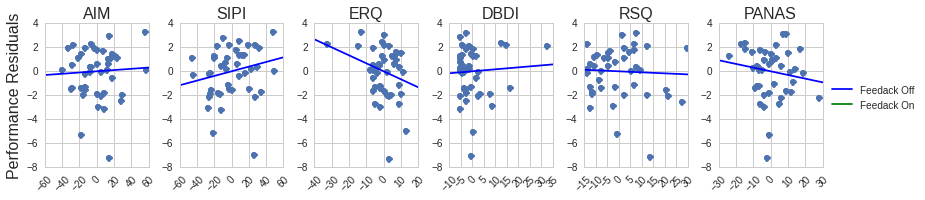

In [58]:
import statsmodels.api as sm
import matplotlib.lines as mlines


# phenoValuesTotal=['V1_CCDERQ_11','V1_CCDERQ_12','V1_CCDRSQ_73','V1_CCDRSQ_74','V1_CCDRSQ_75']
# phenoNames=['Reappraisal','Suppression','Brooding','Depression','Reflection']
phenoValuesTotal=['V1_CCDAIM_41','V1_CCDSIPI_49','V1_CCDERQ_13','V1_DBDI_22','V1_CCDRSQ_72','V1_CCDPANAS_23']
phenoNames=['AIM','SIPI','ERQ','DBDI','RSQ','PANAS']

fig, axes = plt.subplots(1,6,figsize=(12, 2.5))

sns.set_style("whitegrid")

phenoFile='/home/jmuraskin/Projects/CCD/Pheno/narsad+vt_new.csv'

fb=1
for phenoV,ax,phenoName in zip(phenoValuesTotal,axes,phenoNames):
    
#     for fb in [0,1]:
    pheno=read_csv(phenoFile)
    pheno=pheno.set_index('participant').fillna(value=0)
    subject_list=goodsubj

    addmotion=True
    addNOFB=False
    addScanOrder=True
    addWander=False



    phenoValues=['V1_DEM_001','V1_DEM_002',phenoV]


    modelInfo=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
    motionInfo=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
    motionInfoNFB=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['meanFD']
    scanorder=GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='FEEDBACK'],axis=0)].groupby('Subject_ID').mean()['scanorder']
    NOFB=np.arctanh(GroupDF[np.all([GroupDF.Subject_ID.isin(subject_list),GroupDF.FB=='NOFEEDBACK'],axis=0)].groupby('Subject_ID').mean()['modelcorr'])
    if addmotion:

        pheno=pheno.loc[subject_list][phenoValues]
        phenoValues+=['meanFD']
        if fb:
            pheno['meanFD']=motionInfo+motionInfoNFB
        else:
            pheno['meanFD']=motionInfoNFB               
#             modelX=pheno

    else:
        modelX=pheno.loc[subject_list][phenoValues]

    if addNOFB:
        phenoValues+=['NOFB']
        modelX['NOFB']=NOFB

    if addScanOrder:
        phenoValues+=['scanorder']
        pheno['scanorder']=scanorder

    if addWander:
        if fb:
            pheno['Focus']=fw_spatial.loc[goodsubj,[4],'FEEDBACK'].values
        else:
            pheno['Focus']=fw_spatial.loc[goodsubj,[4],'NOFEEDBACK'].values    

    if fb:
        inputs=fw_spatial.loc[goodsubj,[3],'FEEDBACK'].values-fw_spatial.loc[goodsubj,[3],'NOFEEDBACK'].values
    else:
        inputs=fw_spatial.loc[goodsubj,[3],'NOFEEDBACK'].values
    modelX=pheno.sub(pheno.mean())    
    results=CCD_packages.runRLMR(inputs,modelX,phenoValues,RLM=True,plotFigure=False)


    sm.graphics.plot_ccpr(results, phenoV, ax=ax)
    sns.set_style("whitegrid")
    print 'Feedback: %d -- Pheno: %s -- P-Value: %0.3f' % (fb,phenoName,results.pvalues[phenoV])
    
    
    
    
    
#     ax.plot(ax.lines[3].get_xdata(),ax.lines[3].get_ydata(),'g')
    
    
    
    title=phenoName 
    title+= '*' if results.pvalues[phenoV]<0.05 else ''
    
    ax.set_title(title,fontsize=16)
    
    ax.set_xlabel('')
    if phenoName=='AIM':
        ax.set_ylabel('Performance Residuals',fontsize=16)
    else:
        ax.set_ylabel('')
#     ax.set_title('')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    if phenoName=='PANAS':
        blue_line = mlines.Line2D([], [], color='blue', label='Feedack Off')
        green_line = mlines.Line2D([], [], color='green', label='Feedack On')
        plt.legend(handles=[blue_line,green_line],bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#         ax.legend(['Feedback Off','Feedback Off','Feedback On','Feedback On'],numpoints=1,bbox_to_anchor=(1.05, .6), loc=2, borderaxespad=0.)
#     handles, labels = ax.get_legend_handles_labels()
#        

#     ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
fig.subplots_adjust(wspace=.3,bottom=.1,top=.9,left=.05,right=.95)
fig.savefig('%s/Wander_Spatial_Sub_Scales.png' % CCD_packages.saveFigureLocation,dpi=300)
    



In [48]:
goodFocus=fw_spatial.loc[:,3,'FEEDBACK']<0
goodFocus=goodFocus.index.values[goodFocus]

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning:

in the future, boolean array-likes will be handled as a boolean array index



In [49]:
goodFocus

array(['CCD014', 'CCD014', 'CCD014', 'CCD014', 'CCD014', 'CCD014',
       'CCD014', 'CCD014', 'CCD012', 'CCD014', 'CCD014', 'CCD012',
       'CCD014', 'CCD014', 'CCD012', 'CCD012', 'CCD012', 'CCD014',
       'CCD014', 'CCD014', 'CCD012', 'CCD014', 'CCD014', 'CCD012',
       'CCD012', 'CCD014', 'CCD014', 'CCD014', 'CCD014', 'CCD012',
       'CCD012', 'CCD014', 'CCD012', 'CCD014', 'CCD014', 'CCD012',
       'CCD014', 'CCD014', 'CCD012', 'CCD012', 'CCD014', 'CCD012', 'CCD012'], dtype=object)

In [211]:
GroupDF['fb']=GroupDF.FB=='FEEDBACK'

scanOrder=GroupDF.groupby(['Subject_ID','scanorder'])['fb'].mean()



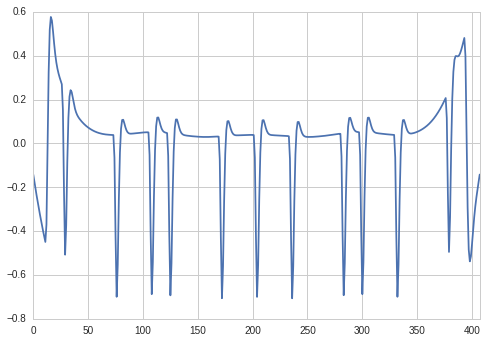

In [155]:
tmp=read_csv('PPI.csv')
tmpSubj=read_csv('/home/jmuraskin/Projects/CCD/working_v1/FB_Signal/CCD014_run1.csv')
tmp['Stim'].plot()

NameError: name 'tmpSubj' is not defined

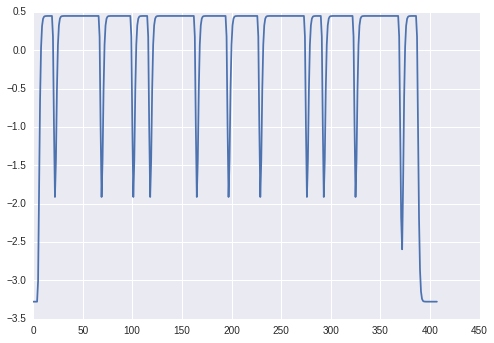

In [12]:
from scipy.stats import zscore
plt.plot(zscore(np.convolve(wander-focus, hrf_at_trs,mode='same')))
plt.plot(zscore(np.convolve(tmpSubj.score,hrf_at_trs,mode='same')))
plt.plot(zscore(np.convolve(wander-focus, hrf_at_trs,mode='same')*zscore(np.convolve(tmpSubj.score,hrf_at_trs,mode='same'))))
plt.ylim([-4,4])

In [15]:
from nilearn import input_data
import os


folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/ConjAnalysis/'
# folder='/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/paired-Ttest/motionRMS-1.000000-subjperf-15/DMN_PC/cope0_age_gender/'


os.system('fslmaths %s/cluster_mask_cope3-cope4-zstat1-conj.nii.gz -bin %s/threshold_mask' % (folder,folder))

# Extracting signal from sphere around DMN seeds
masker = input_data.NiftiMasker(mask_img='%s/threshold_mask.nii.gz' % folder,
    mask_strategy='background',
    detrend=False, standardize=True, memory='nilearn_cache', 
    memory_level=1, verbose=2)

# fb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/Feedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
# nofb_filename = '/home/jmuraskin/Projects/CCD/working_v1/groupAnalysis/randomise/noFeedback/motionRMS-1.000000/cope1_age_gender/cope1_merged.nii.gz'
masker.fit()


count=0
group=[]
for subj in goodsubj:

    tmpSubj=read_csv('/home/jmuraskin/Projects/CCD/working_v1/FB_Signal/%s_run%d.csv' % (subj,scanorder.loc[subj]))
    bold_signal = masker.transform('/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/functional_mni_other_resolutions_smooth/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz' % (subj,scanorder.loc[subj]))
    group+=[count]*408
    if count==0:
        X=bold_signal
        y=np.convolve(tmpSubj.score,hrf_at_trs,mode='same')
    else:
        X=np.concatenate((X,bold_signal))
        y=np.concatenate((y,np.convolve(tmpSubj.score,hrf_at_trs,mode='same')))
    count+=1
    

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[Memory]    0.1s, 0.0min: Loading resample_img...
[Memory]    0.1s, 0.0min: Loading filter_and_mask...
[Memory]    0.2s, 0.0min: Loading filter_and_mask...
[Memory]    0.2s, 0.0min: Loading filter_and_mask...
[Memory]    0.3s, 0.0min: Loading filter_and_mask...
[Memory]    0.4s, 0.0min: Loading filter_and_mask...
[Memory]    0.4s, 0.0min: Loading filter_and_mask...
[Memory]    0.5s, 0.0min: Loading filter_and_mask...
[Memory]    0.6s, 0.0min: Loading filter_and_mask...
[Memory]    0.6s, 0.0min: Loading filter_and_mask...
[Memory]    0.7s, 0.0min: Loading filter_and_mask...
[Memory]    0.8s, 0.0min: Loading filter_and_mask...
[Memory]    0.9s, 0.0min: Loading filter_and_mask...
[Memory]    1.0s, 0.0min: Loading filter_and_mask...
[Memory]    1.0s, 0.0min: Loading filter_and_mask...
[Memory]    1.1s, 0.0min: Loading filter_and_mask...
[Memory]    1.2s, 0.0min: Loading filter_and_mask...
[Memory]    1.3s, 0.0min: L

(17544, 2142)

In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut,GroupKFold



In [17]:
# y=zscore(np.convolve(tmpSubj.score,hrf_at_trs,mode='same'))
clf = SVR(C=1.0, epsilon=0.2)

logo = GroupKFold(n_splits=10).get_n_splits(X,y,groups=group)
# logo = LeaveOneGroupOut().split(X, y, groups=group)
# scores=[]
# for train, test in logo.:
    
#     clf.fit(X[train,:], y[train])
#     y_pred=clf.predict(X[test,:])
#     scores.append(r2_score(y[test],y_pred))
scores = cross_val_score(clf, X, y, cv=logo,scoring='r2',n_jobs=10) 

In [18]:
scores

array([-0.04392251, -0.08621475, -0.04548756, -0.00930447, -0.06795787,
       -0.01344262, -0.16960263, -0.01574106, -0.04196412, -0.08343499])

In [ ]:
plt.plot(range(408),clf.predict(bold_signal),label='predict')
plt.plot(range(408),y,label='FB')

In [208]:
bold_signal = masker.transform('/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/CCD016_data_/functional_mni_other_resolutions_smooth/_scan_feedback_1/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz')

________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask('/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/CCD016_data_/functional_mni_other_resolutions_smooth/_scan_feedback_1/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz', 
<nibabel.nifti1.Nifti1Image object at 0x7f0f82f73090>, { 'detrend': False,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, copy=True, memory_level=1, verbose=2, memory=Memory(cachedir='nilearn_cache/joblib'))
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/CCD

In [209]:
tmpSubj=read_csv('/home/jmuraskin/Projects/CCD/working_v1/FB_Signal/CCD016_run1.csv')

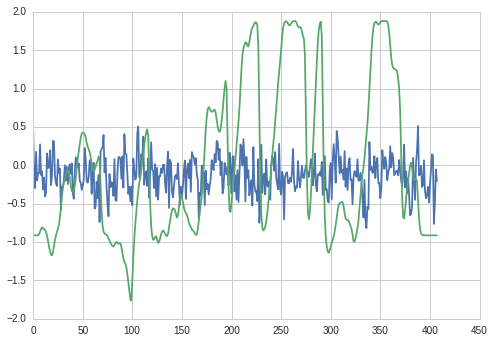

In [210]:
plt.plot(range(408),clf.predict(bold_signal),label='predict')
plt.plot(range(408),zscore(np.convolve(tmpSubj.score,hrf_at_trs,mode='same')),label='FB')

In [214]:
scanorder

Subject_ID
CCD012    1.0
CCD014    1.0
CCD015    2.0
CCD016    1.0
CCD017    2.0
CCD018    1.0
CCD019    2.0
CCD020    1.0
CCD021    2.0
CCD022    1.0
CCD023    2.0
CCD024    1.0
CCD025    2.0
CCD026    1.0
CCD027    2.0
CCD031    1.0
CCD032    2.0
CCD040    2.0
CCD041    2.0
CCD042    1.0
CCD052    1.0
CCD053    1.0
CCD059    2.0
CCD060    2.0
CCD063    1.0
CCD064    1.0
CCD067    1.0
CCD071    1.0
CCD073    1.0
CCD074    2.0
CCD081    2.0
CCD082    1.0
CCD084    1.0
CCD085    2.0
CCD088    1.0
CCD089    1.0
CCD090    2.0
CCD091    2.0
CCD092    1.0
CCD094    2.0
CCD095    1.0
CCD097    2.0
CCD099    1.0
Name: scanorder, dtype: float64